# Comparing Cable News Hosts

### Goal:
The goal of this notebook is to explore the commentary of the hosts for each of the three main cable news networks using unsupervised learning methods.

### Shows
Fox News:
   * Tucker Carlson Tonight
   * Hannity
   
CNN:
   * Erin Burnett Outfront
   * Anderson Cooper 360
    
MSNBC:
   * All In with Chris Hayes
   * The Rachel Maddow Show

### Data Sources:
I used a combination of Selenium and BeautifulSoup to scrape the transcripts. For CNN and MSNBC, I pulled from their respective websites. For Fox News, I used Fox News's website to pull Hannity and used Archive.org's transcipts to pull Tucker Carlson Tonight. 



### Date Range:
I pulled data from the beginning of 2016 but the majority of my analysis comes from the beginning of 2017 onward.


### Conclusions:
Fox News's success is due to many factors. Fox News exploits behavioral economic biases to beat the competition consistently. Three of the noticeable ones that I explore in this notebook are the following:


* **Emotion** - Fox News hosts make a noticeably higher amount of statements that are emotional. Using the VADER Sentiment tool, I plotted positive and negative statements by each host for each transcript. Fox News consistently appears to have a higher level of negative statements compared to the other networks. By stoking negative emotions in their audiences, they exploit the negativity bias of their audiences.


* **Catchphrases** -  Just as Trump created memorable catchphrases for his campaign rivals (we all remember "Low Energy Jeb" and "Crooked Hillary"), Fox News hosts have memorable catchphrases that their audiences can grab onto and remember. Using ngram analysis, I was able to derive common phrases for each host. While MSNBC and CNN hosts refer to newspapers (like "Wall Street Journal" and "New York Times") and generic statements (like "We'll be right back"), Fox News hosts have memorable lines. For Hannity, he coined the phrase "Destroy Trump media" to refer mainstream media sources. For Tucker Carlson, the combination of the phrase "the show that is the sworn enemy of lying, pomposity, smugness, and groupthink" appeared multiple times. 


* **Create an Enemy** -  Fox News hosts have successfully created multiple enemies that allow them to frame an issue they bring up. Using NMF  topic modeling, I was able to compare the topics that the hosts focused on. For Hannity, he has created an enemy by tying Hillary Clinton to multiple issues, including the Steele Dossier, Special Counsel invesitigation, and the most surprising, the #MeToo movement. Additionally, he's created an enemy in the media which is the topic of one grouping and mentioned in another. By associating Hillary Clinton with multiple topics, he is able to frame issues in his audience's heads by exploiting the availability heuristic.




In [159]:
#General Imports
import pandas as pd
from scipy import sparse as sp
import time
import re
import numpy as np
from functools import partial
from __future__ import print_function
import pickle as pk
import os
from operator import itemgetter
from collections import Counter
import warnings

# Visualization
import pyLDAvis.gensim
import matplotlib.pyplot as plt

# Web Related
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import requests

# SKLearn
import sklearn
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as ESW

# TextBlob
from textblob import TextBlob

# NLTK
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

# Gensim
from gensim.corpora import Dictionary
from gensim.models import Phrases, LdaModel

# WordCloud
from wordcloud import WordCloud

#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.enable_notebook()

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
# mv chrome driver from Downloads to Applications 
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver


driver = webdriver.Chrome(chromedriver)
driver.get("http://www.foxnews.com/category/shows/hannity/transcript.html")

# Fox News

### Hannity URLs

In [4]:
for a in range(1,45):
    driver.find_element_by_xpath('//footer/div[@class="button load-more js-load-more"]/a').click()
    time.sleep(1.5)


In [5]:
hannity_urls = []
for n in range(1,250):
    selector = '//article[' + str(n) + ']//a'
    url = driver.find_element_by_xpath(selector).get_attribute('href')
    if 'foxnews.com/transcript' in url:
        hannity_urls.append(url)


##### Content

In [6]:
driver.get('http://www.foxnews.com/category/shows/hannity/transcript.html')

In [7]:
title = []
date = []
content = []

In [8]:
for hannity in hannity_urls:
    driver.get(hannity)
    t = driver.find_element_by_xpath('//article//h1').text
    title.append(t)
    u = hannity[34:44]
    date.append(u)
    c = driver.find_element_by_xpath('//div[@class="article-body"]').text
    c = c[:-420]
    content.append(c)

In [9]:
hannity_all = [title,date,content,hannity_urls]

In [10]:
df = pd.DataFrame(hannity_all)

In [11]:
# df = df.transpose()

In [307]:
df.columns = ['Title','Date','Content','URL']

In [12]:
def remove_update_hannity(s):
    c = 'final form and may be updated'
    start_count = s.find(c)+30
    s = s[start_count:]
    if s[0] == '\n':
        return s[1:]
    else:
        return s

In [13]:
df['Content'] = df['Content'].apply(remove_update_hannity)

In [14]:
df['Show'] = 'Hannity'

In [16]:
df.to_pickle('Pickles/df_Hannity.pickle')

### Tucker Carlson

In [18]:
driver.get('https://archive.org/details/tv?q=tucker+carlson&and%5B%5D=program%3A"Tucker+Carlson+Tonight"&sort=-publicdate')

In [19]:
for n in range(15):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(4)

In [21]:
tucker_links_only = re.compile('\/details\/FOXNEWSW\_')
content_tc = driver.find_element_by_xpath('//*').get_attribute('innerHTML')
soup = BeautifulSoup(content_tc, 'lxml')
tclinks = soup.findAll('a',attrs ={'href': tucker_links_only})

In [22]:
tc_narrowed_links = []
for link in tclinks:
    tc_narrowed_links.append(link['href'])

In [23]:
tc_text = []
for text in tclinks:
    #Get Text
    test_link = text.getText().strip()
    #Search for 2016, 2017, 2018 in text
    tc_year = re.search('2016|2017|2018', test_link)
    # Get index of last value
    end_year = tc_year.end()
    # Strip Value
    text = text.getText().strip()[36:end_year]
    tc_text.append(text)

In [24]:
d = OrderedDict(zip(tc_text, tc_narrowed_links))

In [25]:
tc_cleaned_links = []
for k, v in d.items():
    tc_cleaned_links.append('https://archive.org' + v)

In [26]:
tc_pd_content = []
tc_pd_link = []
for link in tc_cleaned_links:
    driver.get(link)
    text = driver.find_element_by_xpath('//*[@id="cols"]').text
    tc_pd_content.append(text)
    tc_pd_link.append(link)


In [27]:
date_tc = [k for k, v in d.items()]
tucker_all = [date_tc, tc_cleaned_links, tc_pd_content]
df_tc = pd.DataFrame(tucker_all)
df_tc = df_tc.transpose()
df_tc.columns = ['Date','URLs','Content']
df_tc['Show'] = 'Tucker Carlson Tonight'
df_tc['Title'] = 'Tucker Carlson'

In [28]:
df_tc.to_pickle('Pickles/df_tucker_carlson.pickle')

# MSNBC

### Rachel Maddow

In [29]:
driver.get('http://www.msnbc.com/transcripts/rachel-maddow-show/2016/2')

In [30]:
driver.get(maddow_urls2[125])

In [234]:
maddow_urls = []
for year in [2016,2017,2018]:
    for month in range(1,13):
        if year ==2018 and month ==3:
            break
        else:
            driver.get('http://www.msnbc.com/transcripts/rachel-maddow-show/' + str(year) + '/' + str(month))
            a = 0
            while True:
                a += 1
                selector_rm = '//*[@id="block-system-main"]//div[@class="item-list"][1]//li[' + str(a) + ']//a'
                try:
                    url = driver.find_element_by_xpath(selector_rm).get_attribute('href')
                    maddow_urls.append(url)
                except:
                    break

maddow_urls

['http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-29',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-28',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-27',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-26',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-25',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-22',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-20',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-19',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-18',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-15',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-14',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-13',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-11',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-08',
 'http://www.msnbc.com/transcripts/rachel-maddow-show/2016-01-

In [31]:
maddow_urls2 = maddow_urls[:105] + maddow_urls[112:]

In [32]:
date_rm = []
url_rm = []
content_rm = []
for maddow in maddow_urls2:
    driver.get(maddow)
    date = maddow[52:62]
    date_rm.append(date)
    url = maddow
    url_rm.append(url)
    c = driver.find_element_by_xpath('//*[@id="block-system-main"]//div[@class="panel-pane pane-entity-field pane-node-body"]//div[@class="pane-content"]').text
    content_rm.append(c)


In [285]:
content_rm

476

In [33]:
maddow_all = [date_rm, url_rm, content_rm]
df_rm = pd.DataFrame(maddow_all)
df_rm = df_rm.transpose()
df_rm.columns = ['Date','Content','URL']


In [34]:
df_rm['Title'] = 'Rachel Maddow'
df_rm['Show'] = 'The Rachel Maddow Show'

In [35]:
df_rm.rename(columns={'Content':'URLs','URL':'Content'}, inplace=True)

In [37]:
df_rm['Content'] = df_rm['Content'].apply(remove_msnbc_copyright)

In [38]:
df_rm.to_pickle('Pickles/df_RachelMaddow.pickle')

In [2]:
df_rm = pd.read_pickle('Pickles/df_RachelMaddow.pickle')

In [4]:
df_rm.head()

,Date,URLs,Content,Title,Show
0,2016-01-29,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show
1,2016-01-28,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show
2,2016-01-27,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show
3,2016-01-26,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show
4,2016-01-25,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show


### Chris Hayes

In [39]:
driver.get('http://www.msnbc.com/transcripts/all-in')

In [370]:
chrishayes_urls = []
for year in [2016,2017,2018]:
    for month in range(1,13):
        if year ==2018 and month ==3:
            break
        else:
            driver.get('http://www.msnbc.com/transcripts/all-in/' + str(year) + '/' + str(month))
            a = 0
            while True:
                a += 1
                selector_rm = '//*[@id="block-system-main"]//div[@class="item-list"][1]//li[' + str(a) + ']//a'
                try:
                    url = driver.find_element_by_xpath(selector_rm).get_attribute('href')
                    chrishayes_urls.append(url)
                except:
                    break

chrishayes_urls

['http://www.msnbc.com/transcripts/all-in/2016-01-29',
 'http://www.msnbc.com/transcripts/all-in/2016-01-28',
 'http://www.msnbc.com/transcripts/all-in/2016-01-27',
 'http://www.msnbc.com/transcripts/all-in/2016-01-26',
 'http://www.msnbc.com/transcripts/all-in/2016-01-25',
 'http://www.msnbc.com/transcripts/all-in/2016-01-22',
 'http://www.msnbc.com/transcripts/all-in/2016-01-21',
 'http://www.msnbc.com/transcripts/all-in/2016-01-20',
 'http://www.msnbc.com/transcripts/all-in/2016-01-19',
 'http://www.msnbc.com/transcripts/all-in/2016-01-18',
 'http://www.msnbc.com/transcripts/all-in/2016-01-15',
 'http://www.msnbc.com/transcripts/all-in/2016-01-14',
 'http://www.msnbc.com/transcripts/all-in/2016-01-13',
 'http://www.msnbc.com/transcripts/all-in/2016-01-11',
 'http://www.msnbc.com/transcripts/all-in/2016-01-08',
 'http://www.msnbc.com/transcripts/all-in/2016-01-07',
 'http://www.msnbc.com/transcripts/all-in/2016-01-06',
 'http://www.msnbc.com/transcripts/all-in/2016-01-05',
 'http://w

In [40]:
chrishayes_urls2 = chrishayes_urls[:111] + chrishayes_urls[116:]

In [41]:
date_ch = []
url_ch = []
content_ch = []
title_ch = []
for chris in chrishayes_urls2:
    driver.get(chris)
    date = chris[40:50]
    date_ch.append(date)
    url = chris
    url_ch.append(url)
    c = driver.find_element_by_xpath('//*[@id="block-system-main"]//div[@class="panel-pane pane-entity-field pane-node-body"]//div[@class="pane-content"]').text
    content_ch.append(c)
    titlech = driver.find_element_by_xpath('//*[@id="block-system-main"]//h1').text
    title_ch.append(titlech)

In [42]:
chrishayes_all = [date_ch, url_ch, content_ch, title_ch]
df_ch = pd.DataFrame(chrishayes_all)
df_ch = df_ch.transpose()
df_ch.columns = ['Date','URLs','Content', 'Title']

In [386]:
df_ch.head()

,Date,URLs,Content,Title
0,2016-01-29,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/29/2016"
1,2016-01-28,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/28/2016"
2,2016-01-27,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/27/2016"
3,2016-01-26,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/26/2016"
4,2016-01-25,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/25/2016"


In [43]:
df_ch['Show'] = 'All in with Chris Hayes'

In [44]:
def remove_msnbc_copyright(x):
    x = x[:x.find('THIS IS A RUSH TRANSCRIPT.')]
    return x

In [45]:
df_ch['Content'] = df_ch['Content'].apply(remove_msnbc_copyright)

In [46]:
df_ch.to_pickle('Pickles/df_ChrisHayes.pickle')

# CNN

### Anderson Cooper 360

#### Get URLs

In [47]:


content = requests.get('http://transcripts.cnn.com/TRANSCRIPTS/acd.html').text
soup = BeautifulSoup(content,'lxml')

aaa = soup.findAll('a',href=True)

ac360_urls = []
for i in aaa[3:-1]:
    ac360_urls.append(f"http://transcripts.cnn.com/{i['href']}")

In [326]:
ac360_urls

['http://transcripts.cnn.com//TRANSCRIPTS/1802/20/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/20/acd.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/19/acd.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/19/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/16/acd.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/16/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/15/acd.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/15/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/14/acd.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/14/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/13/acd.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/13/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/12/acd.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/12/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/09/acd.02.html',
 'http://transcripts.cnn.com//TRANSCRIPT

In [48]:
ac360_urls = ac360_urls[:926]

#### Get Content

In [49]:
ac360title = []
ac360content = []
ac360date = []
ac360shownum = []
for url in ac360_urls:
    driver.get(url)
    try:
        ac_title = driver.find_element_by_xpath('//*[@id="cnnArticleWireFrame"]//p[@class="cnnTransSubHead"]').text
        ac360title.append(ac_title)
        ac_content = driver.find_element_by_xpath('//*[@id="cnnArticleWireFrame"]//p[@class="cnnBodyText"][last()]').text
        ac360content.append(ac_content)
        ac_show_num = url[-7:-5]
        ac360shownum.append(ac_show_num)
        acdate = url[-19:-17]+ '/' + url[-17:-12]
        ac360date.append(acdate)
    except:
        pass

In [50]:
ac360_all = [ac360title, ac360date, ac360_urls, ac360content, ac360shownum]
df_ac = pd.DataFrame(ac360_all)
df_ac = df_ac.transpose()
df_ac.columns = ['Title','Date','URLs','Content', 'ShowNum']
df_ac['Show'] = 'Anderson Cooper 360'

In [363]:
df_ac.head()

,Title,Date,URLs,Content,ShowNum,Show
0,"Pres. Trump Tweets: ""We Must Now Focus On Stre...",18/02/20,http://transcripts.cnn.com//TRANSCRIPTS/1802/2...,(COMMERCIAL BREAK)\n\n[21:00:27] ANDERSON COOP...,02,Anderson Cooper 360
1,President Trump Blames President Obama for Rus...,18/02/20,http://transcripts.cnn.com//TRANSCRIPTS/1802/2...,"[20:00:07] ANDERSON COOPER, CNN HOST: Good eve...",01,Anderson Cooper 360
2,President Trump Uses Florida Massacre to Attac...,18/02/19,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"[20:00:08] ANDERSON COOPER, CNN HOST: Good eve...",01,Anderson Cooper 360
3,Pres. Trump Slams FBI's Handling of Tip on Sch...,18/02/19,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,(COMMERCIAL BREAK)\n\n[21:00:16] ANDERSON COOP...,02,Anderson Cooper 360
4,Mueller Charges 13 Russians with Interfering i...,18/02/16,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"[20:00:09] ANDERSON COOPER, CNN HOST: Good eve...",01,Anderson Cooper 360


In [364]:
df_ac.to_pickle('Pickles/df_ac360.pickle')

### Erin Burnett

#### Get URLs

In [51]:
driver.get('http://transcripts.cnn.com/TRANSCRIPTS/ebo.html')

In [52]:
content = requests.get('http://transcripts.cnn.com/TRANSCRIPTS/ebo.html').text
soup = BeautifulSoup(content,'lxml')

aaa = soup.findAll('a',href=True)

ebo_urls = []
for i in aaa[3:-1]:
    ebo_urls.append(f"http://transcripts.cnn.com/{i['href']}")


In [353]:
ebo_urls

['http://transcripts.cnn.com//TRANSCRIPTS/1802/20/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/19/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/16/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/15/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/14/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/13/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/12/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/09/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/08/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/07/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/06/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/05/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1802/01/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1801/31/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPTS/1801/30/ebo.01.html',
 'http://transcripts.cnn.com//TRANSCRIPT

In [53]:
ebo_urls = ebo_urls[:552]

#### Get Content

In [54]:
ebo_title = []
ebo_content = []
ebo_date = []
for url in ebo_urls:
    driver.get(url)
    try:
        ebotitle = driver.find_element_by_xpath('//*[@id="cnnArticleWireFrame"]//p[@class="cnnTransSubHead"]').text
        ebo_title.append(ebotitle)
        ebocontent = driver.find_element_by_xpath('//*[@id="cnnArticleWireFrame"]//p[@class="cnnBodyText"][last()]').text
        ebo_content.append(ebocontent)
        ebodate = url[-19:-17]+ '/' + url[-17:-12]
        ebo_date.append(ebodate)
    except:
        pass

In [55]:
ebo_all = [ebo_title, ebo_date, ebo_urls, ebo_content]
df_ebo = pd.DataFrame(ebo_all)
df_ebo = df_ebo.transpose()
df_ebo.columns = ['Title','Date','URLs','Content']
df_ebo['Show'] = 'Erin Burnett Outfront'

In [367]:
df_ebo.head()

,Title,Date,URLs,Content,Show
0,WH Claims Trump Acknowledged Russia Meddling B...,18/02/20,http://transcripts.cnn.com//TRANSCRIPTS/1802/2...,"WOLF BLITZER, CNN ANCHOR: Parents and both the...",Erin Burnett Outfront
1,Trump Returns to WH Amid New Developments in R...,18/02/19,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"[19:00:02] WOLF BLITZER, CNN HOST: Rick Scott ...",Erin Burnett Outfront
2,Mueller Issues First Charges Alleging Russian ...,18/02/16,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"(COMMERCIAL BREAK)\n\n[19:00:23] JIM SCIUTTO, ...",Erin Burnett Outfront
3,Authorities: Ex-Student Confessed to Opening F...,18/02/15,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"WOLF BLITZER, CNN HOST: That's it for me. Than...",Erin Burnett Outfront
4,"Police: 17 Dead In Florida School Shooting, Su...",18/02/14,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"WOLF BLITZER, CNN ANCHOR: Our special live cov...",Erin Burnett Outfront


In [56]:
df_ebo.to_pickle('Pickles/df_ErinBurnett.pickle')

## Cleaning

In [5]:
df_h = pd.read_pickle('Pickles/df_Hannity.pickle')
df_ch = pd.read_pickle('Pickles/df_ChrisHayes.pickle')
df_rm = pd.read_pickle('Pickles/df_RachelMaddow.pickle')
df_ac = pd.read_pickle('Pickles/df_ac360.pickle')
df_ebo = pd.read_pickle('Pickles/df_ErinBurnett.pickle')
df_tc = pd.read_pickle('Pickles/df_tucker_carlson.pickle')

In [6]:
df_ch.head()

,Date,URLs,Content,Title,Show
0,2016-01-29,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/29/2016",All in with Chris Hayes
1,2016-01-28,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/28/2016",All in with Chris Hayes
2,2016-01-27,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/27/2016",All in with Chris Hayes
3,2016-01-26,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/26/2016",All in with Chris Hayes
4,2016-01-25,http://www.msnbc.com/transcripts/all-in/2016-0...,Transcript:\nShow: ALL IN with CHRIS HAYES\nDa...,"All In with Chris Hayes, Transcript 1/25/2016",All in with Chris Hayes


In [7]:
df_ch['Date'] = pd.to_datetime(df_ch.Date, format='%Y-%m-%d')
df_rm['Date'] = pd.to_datetime(df_rm.Date, format='%Y-%m-%d')
df_ebo['Date'] = pd.to_datetime(df_ebo.Date, format='%y/%m/%d')
df_ac['Date'] = pd.to_datetime(df_ac.Date, format='%y/%m/%d')
df_h['Date'] = pd.to_datetime(df_h.Date, format = '%Y/%m/%d')
df_tc['Date'] = pd.to_datetime(df_tc['Date'], format="%B %d, %Y")
df_ac['Show'] = df_ac['Show'] + ' - ' +  df_ac['ShowNum']
df_ac.drop('ShowNum', axis=1, inplace=True)

In [8]:
df_h.rename(columns = {'URL':'URLs'}, inplace=True) 

Define networks

In [9]:
df_ch['Network'] = 'MSNBC'
df_rm['Network'] = 'MSNBC'
df_ebo['Network'] = 'CNN'
df_ac['Network'] = 'CNN'
df_tc['Network'] = 'Fox News'
df_h['Network'] = 'Fox News'

In [10]:
df_rm.head()

,Date,URLs,Content,Title,Show,Network
0,2016-01-29,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
1,2016-01-28,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
2,2016-01-27,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
3,2016-01-26,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
4,2016-01-25,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC


In [11]:
df_ebo.head()

,Title,Date,URLs,Content,Show,Network
0,WH Claims Trump Acknowledged Russia Meddling B...,2018-02-20,http://transcripts.cnn.com//TRANSCRIPTS/1802/2...,"WOLF BLITZER, CNN ANCHOR: Parents and both the...",Erin Burnett Outfront,CNN
1,Trump Returns to WH Amid New Developments in R...,2018-02-19,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"[19:00:02] WOLF BLITZER, CNN HOST: Rick Scott ...",Erin Burnett Outfront,CNN
2,Mueller Issues First Charges Alleging Russian ...,2018-02-16,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"(COMMERCIAL BREAK)\n\n[19:00:23] JIM SCIUTTO, ...",Erin Burnett Outfront,CNN
3,Authorities: Ex-Student Confessed to Opening F...,2018-02-15,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"WOLF BLITZER, CNN HOST: That's it for me. Than...",Erin Burnett Outfront,CNN
4,"Police: 17 Dead In Florida School Shooting, Su...",2018-02-14,http://transcripts.cnn.com//TRANSCRIPTS/1802/1...,"WOLF BLITZER, CNN ANCHOR: Our special live cov...",Erin Burnett Outfront,CNN


In [12]:
df_h.head()

,Title,Date,Content,URLs,Show,Network
0,DOJ to probe potential Obama-era surveillance ...,2018-02-19,"SEAN HANNITY, FOX NEWS HOST: Hey, Tucker. Grea...",http://www.foxnews.com/transcript/2018/02/19/d...,Hannity,Fox News
1,Hannity: Examining key points from Russian ind...,2018-02-16,"SEAN HANNITY, HOST: This is a Fox News alert. ...",http://www.foxnews.com/transcript/2018/02/16/h...,Hannity,Fox News
2,Judge Jeanine: Our kids deserve our protection,2018-02-15,SEAN HANNITY: And welcome to HANNITY. And this...,http://www.foxnews.com/transcript/2018/02/15/j...,Hannity,Fox News
3,Students describe Florida high school shooting...,2018-02-14,"SEAN HANNITY, FOX NEWS HOST: Welcome to HANNIT...",http://www.foxnews.com/transcript/2018/02/14/s...,Hannity,Fox News
4,Newt Gingrich on Obama officials under fire,2018-02-13,Welcome to HANNITY.\nWe have a ton of new brea...,http://www.foxnews.com/transcript/2018/02/13/n...,Hannity,Fox News


In [13]:
df_tc.head()

,Date,URLs,Content,Show,Title,Network
0,2018-02-20,https://archive.org/details/FOXNEWSW_20180221_...,5:00 pm\n excellent student who love the bea...,Tucker Carlson Tonight,Tucker Carlson,Fox News
1,2018-02-19,https://archive.org/details/FOXNEWSW_20180220_...,9:00 pm\n display but not subjected on the d...,Tucker Carlson Tonight,Tucker Carlson,Fox News
2,2018-02-16,https://archive.org/details/FOXNEWSW_20180217_...,"5:00 pm\nin their prayers. good night, everybo...",Tucker Carlson Tonight,Tucker Carlson,Fox News
3,2018-02-15,https://archive.org/details/FOXNEWSW_20180216_...,"5:00 pm\nsinister thoughts, we love to hear th...",Tucker Carlson Tonight,Tucker Carlson,Fox News
4,2018-02-14,https://archive.org/details/FOXNEWSW_20180215_...,"9:00 pm\nthe school, his potential motives and...",Tucker Carlson Tonight,Tucker Carlson,Fox News


In [14]:
df_rm.head()

,Date,URLs,Content,Title,Show,Network
0,2016-01-29,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
1,2016-01-28,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
2,2016-01-27,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
3,2016-01-26,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC
4,2016-01-25,http://www.msnbc.com/transcripts/rachel-maddow...,Transcript:\nShow: THE RACHEL MADDOW SHOW\nDat...,Rachel Maddow,The Rachel Maddow Show,MSNBC


In [15]:
def MSNBC_only_host(line, host):
    line = line.replace('\n', ' ')
    if host == 'MADDOW':
        splitter = '(RACHEL ' + host + ', MSNBC HOST\:|' + host + '\:)'
    else:
        splitter = '(Chris ' + host + ', MSNBC HOST\:|' + host + '\:)'
        print (splitter)
    line = re.split(splitter, line)
    print(line)
    maddow_words = []
    holder = []
    for test in line[2::2]:
        maddow_words.append(test.split(':')[0])
    try:
        for lines in maddow_words:
            while (re.match('(\(|\)|\ |\,|\-|[A-Z])', lines[-1]) is not None):
                lines = lines[:-1]
            holder.append(lines)
        holder = ' '.join(holder)
        return holder
    except:
        return ' '

In [16]:
df_rm['Date'].iloc[5]

Timestamp('2016-01-22 00:00:00')

In [17]:
MSNBC_only_host(df_rm['Content'].iloc[5], 'MADDOW')

['Transcript: Show: THE RACHEL MADDOW SHOW Date: January 22, 2016 Guest: Lindsey Smith, Linda Lee ', 'RACHEL MADDOW, MSNBC HOST:', ' And thanks to you at home for joining with us this hour. Happy weekend. Happy Friday. OK, this goes in an unexpected place but trust me, you`re going to enjoy the ride. In May 2008, John McCain had all but wrapped up the Republican presidential nomination. At that point, it was basically just a march to the convention for him. But sometimes candidates hit obstacles in their campaigns that weren`t put there by their opponents. It`s not because one of their rivals for the nomination or a candidate from another party has hit them with something particularly hard. Sometimes, candidates just make their own unforced errors. And John McCain did that in the spring of 2008 when he momentarily hopped into bed with a sort of high-profile guy who it turned out had very, very strong and strongly stated beliefs about among other things the Catholic Church. (BEGIN VIDEO

' And thanks to you at home for joining with us this hour. Happy weekend. Happy Friday. OK, this goes in an unexpected place but trust me, you`re going to enjoy the ride. In May 2008, John McCain had all but wrapped up the Republican presidential nomination. At that point, it was basically just a march to the convention for him. But sometimes candidates hit obstacles in their campaigns that weren`t put there by their opponents. It`s not because one of their rivals for the nomination or a candidate from another party has hit them with something particularly hard. Sometimes, candidates just make their own unforced errors. And John McCain did that in the spring of 2008 when he momentarily hopped into bed with a sort of high-profile guy who it turned out had very, very strong and strongly stated beliefs about among other things the Catholic Church.  That man`s name is John Hagee, a Texas pastor who preaches that the Catholic Church is the whore of Babylon that will be devoured by the antic

In [18]:
df_rm['Commentator_Only'] = df_rm['Content'].apply(lambda line: MSNBC_only_host(line, 'MADDOW'))
df_ch['Commentator_Only'] = df_ch['Content'].apply(lambda line: MSNBC_only_host(line, 'HAYES'))

['Transcript: Show: THE RACHEL MADDOW SHOW Date: January 29, 2016 Guest: Hank Winchester, Benson Osazee CHRIS HAYES, “ALL IN” HOST: That`s “ALL IN” for this evening. THE RACHEL MADDOW SHOW starts right now. Good evening, Rachel. ', 'RACHEL MADDOW, MSNBC HOST:', ' Good evening, my friend. Hope you have a good weekend. HAYES: I will see you from Des Moines. ', 'MADDOW:', ' Yes, when do you go? HAYES: I`m going Sunday. And I will see you Sunday evening on the camera machine. ', 'MADDOW:', ' Do you need to borrow any warm clothes? HAYES: I have warm clothes. Thank you very much. ', 'MADDOW:', ' OK, very good. I`ll see you then, Chris. All right. Thanks to you at home for joining us this hour. He`s foreshadowing something I`m about to explain in detail. You know, Fridays are supposed to be slow news days. Today was not a slow news day. We`ve got a big show coming up, including some news that broke tonight and in fact, it`s still breaking tonight in the state of Flint, Michigan, the mayor of

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [19]:
def CNN_only_host(line, host):
    if host == 'BURNETT':
        splitter = '((ERIN BURNETT\, CNN (ANCHOR|HOST)(\:|\,))|BURNETT:)'
    elif host == 'COOPER':
        splitter = '((ANDERSON COOPER\, CNN (ANCHOR|HOST)(\:|\,))|COOPER:)'
    try:
        holder = []
        cnn_holder = []
        line = line.replace('\n', ' ')
        line = re.sub('\[(.*?)\]','', line)
        line = re.split(splitter, line)
        for x in line[::5]:
            cnn_holder.append(x.split(':')[0])
        for lines in cnn_holder[1:]:
            while (re.match('(\(|\)|\ |\,|\-|[A-Z])', lines[-1]) is not None):
                lines = lines[:-1]
            holder.append(lines)
        holder = " ".join(holder)
        return (holder)
    except:
        return ' '

In [20]:
df_ebo['Commentator_Only'] = df_ebo['Content'].apply(lambda line: CNN_only_host(line, 'BURNETT'))
df_ac['Commentator_Only'] = df_ac['Content'].apply(lambda line: CNN_only_host(line, 'COOPER'))

In [150]:
def hannity_only(x):
    if (('SEAN HANNITY, FOX NEWS HOST:' in x) or ('SEAN HANNITY, HOST:' in x)):
        if (('KIMBERLY GUILFOYLE, FOX NEWS HOST:' not in x[:150]) and ('JEANINE PIRRO, FOX NEWS GUEST HOST:' not in x[:150])):
            quote_holder = []
            holder = []
            all_holder = []
            splitter = '(SEAN HANNITY\, FOX NEWS HOST\:|SEAN HANNITY\, HOST:|SEAN\ HANNITY\:)'
            content = re.split(splitter,x)
            if (content[0] == 'SEAN '):
                content = content[1:]
            removed_hannity = []
            for n in content:
                removed_hannity.append(re.sub(splitter,'', n))
            removed_hannity = list(filter(None, removed_hannity))
            for quote in removed_hannity:
                quote = quote.replace('quote:', 'quote')
                quote = quote.replace('\n',' ')
                quote = re.sub('\(BEGIN VIDEO CLIP(?<=(BEGIN VIDEO CLIP)).*(?=(END VIDEO CLIP))END VIDEO CLIP\)',' ',quote)
                quote_holder.append(quote)
            holder.append(quote_holder[0])
#             print(quote_holder[1])
            try:
                for line in quote_holder[1:]:
                    temp = line.split('HANNITY:')
#                     print(temp)
                    for l in temp:
                        holder.append(l.split(':')[0])
                if  (holder[0] == 'ADVERTISEMENT '):
                    holder = holder[1:]
#                 print(holder)
                for lines in holder:
                    while (re.match('(\ |\,|\-|\:|\ |[A-Z])', lines[-1]) is not None):
                        lines = lines[:-1]
                    all_holder.append(lines)
                all_holder = " ".join(all_holder)
#                 print(all_holder)
                return all_holder
            except:
                return 'Babaganoosh'
        else:
            return 'Guest'
    else:
        return 'Guest'

In [127]:
def hannity_only2test(x):
    if (('SEAN HANNITY, FOX NEWS HOST:' in x) or ('SEAN HANNITY, HOST:' in x)):
        if (('KIMBERLY GUILFOYLE, FOX NEWS HOST:' not in x[:150]) and ('JEANINE PIRRO, FOX NEWS GUEST HOST:' not in x[:150])):
            quote_holder = []
            holder = []
            all_holder = []
            splitter = '(SEAN HANNITY\, FOX NEWS HOST\:|SEAN HANNITY\, HOST:)'
            content = re.split(splitter,x)
            content = content[2:]
#             print(content)
            for quote in content:
                quote = quote.replace('quote:', 'quote')
                quote = quote.replace('\n',' ')
                quote = re.sub('\(BEGIN VIDEO CLIPS?(?<=(BEGIN VIDEO CLIP)(?<=(S))?).*(?=(END VIDEO CLIP))END VIDEO CLIP\)',' ',quote)
                quote_holder.append(quote)
            
#             print(quote_holder)
            try:
                for line in quote_holder:
                    temp = line.split('HANNITY:')
#                     print(temp)
                    for l in temp:
                        holder.append(l.split(':')[0])
                holder2 = []
                for n in holder:
                    p = re.sub('([A-Z]{4,})','',n)
                    holder2.append(p)
                for lines in holder2:
                    while (re.match('(\ |\,|\-|\:|\ |[A-Z]|[0-9])', lines[-1]) is not None):
                        lines = lines[:-1]
                    all_holder.append(lines)
                all_holder = " ".join(all_holder)
                all_holder = re.sub('([A-Z]{4,})','',all_holder)
#                 print(all_holder)
                return all_holder
            except:
                return 'Babaganoosh'
        else:
            return 'Guest'
    else:
        return 'Guest'

In [151]:
df_h['Commentator_Only'] = df_h['Content'].apply(hannity_only)

In [25]:
df_h[df_h.Date =='05-19-2017']['Content'].values

array([ 'ADVERTISEMENT\nSEAN HANNITY, FOX NEWS HOST: This is a "Fox News Alert." Welcome to "Hannity" on a breaking news Friday night. President Trump now traveling for his first overseas trip as commander-in-chief. We\'ll check in with Dr. Sebastian Gorka. He\'ll have reaction. Also tonight, Juan Williams, Jay Sekulow, Byron York, Joe Concha, Lisa Boothe, Ric Grenell, Austan Goolsbee all coming up.\nBut first, all right, the past two weeks -- they\'ve been nothing like we have ever seen before in American history! President Trump has been attacked with lies and innuendo, late-day news dumps, anonymous sources, breathless hyperventilating reporting. Now, I\'m going to explain exactly what the president is up against. This is important. We put it all together in tonight\'s "Opening Monologue."\nAll right, this week, we\'ve been telling you about the five groups that are aligned to try and destroy President Trump. Now, they want to undermine the will of you, the American people. Now, the

In [26]:
print(df_h[df_h.Date == '05-19-2017'].Commentator_Only.values)

[None]


In [27]:
df_h['Content'][2]

"SEAN HANNITY: And welcome to HANNITY. And this is a Fox News alert.\nWe have a lot of breaking news about the Florida high school shooter, confessing to killing 17 people.\nAnd also breaking at this hour, new questions about how all of the warning signs surrounding the gunman, Nikolas Cruz, were missed. What went wrong, and why did so many red flags go unnoticed? We're going to have a comprehensive discussion tonight.\nAlso tonight in the face of unspeakable evil, violence, tragedy, people rose up to protect other people. We're going to show you heroes that saved lives at Marjory Stoneman Douglas High School in Parkland, Florida.\nAnd while politicians, the media, they're all pointing fingers, placing game, giving you the same predictable talking points, tonight, we will offer solutions. How do we protect students at schools all across the country? Answers. That is in tonight's breaking news opening monologue.\nHANNITY: We start tonight with breaking news and details about the investi

In [132]:
fibromyalgia = 'i feel chronic, widespread pain.like most people. fibromyalgia may be invisible to others, but my pain is real. fibromyalgia is thought to be caused by overactive nerves. lyrica is believed to calm these nerves. i\'m glad my doctor prescribed lyrica. for some, lyrica delivers effective relief for moderate to even severe fibromyalgia pain. and improves function. lyrica may cause serious allergic reactions, suicidal thoughts or actions. tell your doctor right away if you have these, new or worse depression, unusual changes in mood or behavior, swelling, trouble breathing, rash, hives, blisters, muscle pain with fever, tired feeling, or blurry vision. common side effects: dizziness, sleepiness, weight gain, swelling of hands, legs and feet. don\'t drink alcohol while taking lyrica. don\'t drive or use machinery until you know how lyrica affects you. those who\'ve had a drug or alcohol problem may be more likely to misuse lyrica. with less pain, i can do more with my family. talk to your doctor today. see if lyrica can help.'
polident = 'did you know there\'s a specialty cleanser that\'s gentle enough for everyday use and cleans better than regular toothpaste? try polident cleanser. it has a four in one cleaning system that kills ten times more odor causing bacteria than regular toothpaste, deep cleans where brushing may miss, helps remove tough stains, and maintains the original color of your dentures when used daily. for a cleaner, fresher, brighter denture, use polident every day.'
ducolex = '(gasping) son? dad! we also know you can avoid drama by getting an annual check-up. so we\'re partnering with cigna to remind you to go see a real doctor. go, know, and take control of your health. it could save your life. doctor poses! dad! cigna. together, all the way. dad! trust #1 doctor recommended dulcolax. use dulcolax tablets for gentle dependable relief. suppositories for relief in minutes. and dulcoease for comfortable relief of hard stools. dulcolax. designed for dependable relief.'
prevagen = 'something for your heart... but do you take something for your brain. with an ingredient originally found in jellyfish, prevagen is the number one selling brain-health supplement in drug stores nationwide. prevagen. the name to remember.'
anoro = 'the moment a fish is pulled out from the water, it\'s a race against time. and keeping it in the right conditions is the best way to get that fish to your plate safely. sometimes the product arrives and the cold chain has been interrupted, and we need to be able to identify where in the cold chain that occurred. we took our world class network and we developed devices to track environmental conditions. this device allows people to understand what\'s happening with the location, but also if it\'s too hot, if it\'s too cold, if it\'s been dropped... it\'s completely unique. if you have a sensor that can keep track of your product, it keeps everybody kind of honest that way. who knew a tiny sensor could help keep the food chain safe?'
geico1 = 'sorry, it\'s a tandem bicycle. what? what?! as long as sloths are slow, you can count on geico saving folks money. fifteen minutes could save you fifteen percent or more on car insurance.'
entyvio = 'if you have moderate to severe ulcerative colitis or crohn\'s, and your symptoms have left you with the same view, it may be time for a different perspective. if other treatments haven\'t worked well enough, ask your doctor about entyvio, the only biologic developed and approved just for uc and crohn\'s. entyvio works by focusing right in the gi-tract to help control damaging inflammation and is clinically proven to begin helping many patients achieve both symptom relief as well as remission. infusion and serious allergic reactions can happen during or after treatment. entyvio may increase risk of infection, which can be serious. while not reported with entyvio, pml, a rare, serious brain infection caused by a virus may be possible. tell your doctor if you have an infection, experience frequent infections, or have flu-like symptoms, or sores. liver problems can occur with entyvio. if your uc or crohn\'s medication isn\'t working for you, ask your gastroenterologist about entyvio. entyvio. relief and remission within reach.'
farmers1 = 'so we know how to cover almost almoanything.hing even a swing set standoff. and we covered it, july first, twenty-fifteen. talk to farmers. we know a thing or two because we\'ve seen a thing or two.'
chantix = 'smoking it takes a lot of planning to be a smoker. it\'s like when am i gonna be able to sneak out of here and go have a cigarette? i just knew i had to quit, and chantix was the method that actually worked for me. along with support, chantix (varenicline) is proven to help people quit smoking. chantix reduced my urge to smoke. when you try to quit smoking, with or without chantix, you may have nicotine withdrawal symptoms. some people had changes in behavior or thinking, aggression, hostility, agitation, depressed mood, or suicidal thoughts or actions with chantix. serious side effects may include seizures, new or worse heart or blood vessel problems, sleepwalking or allergic and skin reactions which can be life-threatening. stop chantix and get help right away if you have any of these. tell your healthcare provider if you\'ve had depression or other mental health problems. decrease alcohol use while taking chantix. use caution when driving or operating machinery. the most common side effect is nausea. thanks to chantix, i did it. ask your doctor if chantix is right for you. many insurance plans cover chantix for a low or $0 copay.'
outback = 'with steak and shrimp? more shrimp. and you know what goes great with that shrimp? you guessed it. more shrimp. steak and unlimited shrimp, starting at $15.99. only at outback.'
miralax = 'for my constipation, my doctor recommended i switch laxatives. stimulant laxatives make your body go by forcefully stimulating the nerves in your colon. miralax is different. it works with the water in your body to hydrate and soften. unblocking your system naturally. miralax.'
rockmortgage = "there's rocket mortgage by quicken loans. apply simply. understand fully. mortgage confidently."
legalzoom = 'at legalzoom, our network of attorneys can help you every step of the way. with an estate plan including wills or a living trust that grows along with you and your family. legalzoom. legal help is here.'
nexium = 'doctors trust. nexium 24hr is the number one choice of doctors and pharmacists for their own frequent heartburn. and all day, all night protection. when it comes to heartburn, trust nexium 24hr.'
medicare = 'approaching medicare eligibility? you may think you can put off checking out your medicare options until you\'re sixty-five, but now is a good time to get the ball rolling. keep in mind, medicare only covers about eighty percent of part b medical costs. the rest is up to you. that\'s where aarp medicare supplement insurance plans insured by unitedhealthcare insurance company come in. like all standardized medicare supplement insurance plans, they could help pay some of what medicare doesn\'t, saving you in out-of-pocket medical costs. you\'ve learned that taking informed steps along the way really makes a difference later. that\'s what it means to go long™. call now and request this free decision guide. it\'s full of information on medicare and the range of aarp medicare supplement plans to choose from based on your needs and budget. all plans like these let you choose any doctor or hospital that accepts medicare patients, and there are no network restrictions. unitedhealthcare insurance company has over thirty years experience and the commitment to roll along with you, keeping you on course. so call now and discover how an aarp medicare supplement plan could go long™ for you. these are the only medicare supplement insurance plans endorsed by aarp, an organization serving the needs of people 50 and over for generations. plus, nine out of ten plan members surveyed say they would recommend their plan to a friend. remember, medicare doesn\'t cover everything. the rest is up to you. call now, request your free decision guide and start gathering the information you need to help you keep rolling with confidence. go long'
commercials = [fibromyalgia, polident, ducolex, prevagen, anoro, geico1, entyvio, farmers1, chantix,
              outback, miralax, rockmortgage, legalzoom, nexium, medicare]

In [133]:
def tucker_only(x):
    if '>> tucker:' in x:
        for commercial in commercials:    
            x = x.replace(commercial, ' ')
        holder = []
        final_holder = []
        tc_timer = re.compile('(\\n)?\d\d?\:\d\d(?<!(pm|am)) (pm|am)\\n')
        test_content = re.sub(tc_timer, ' ', x) 
        test_content = test_content.split('>> tucker:')
        for line in test_content:
            holder.append(line.split('>>')[0])
        for n in holder:
            final_holder.append(n.split('♪')[0])
        result = ' '.join(final_holder)
        return result
    else: 
        return 'Babaganoosh'

In [134]:
df_tc['Commentator_Only'] = df_tc['Content'].apply(tucker_only)


In [147]:

gatsby = TextBlob(df_ac['Commentator_Only'][0])

### Sentiment Analysis

In [77]:
date_start = '2017-8-24'
date_end = '2017-8-31'

In [78]:
ac_pol = []
ac_sub = []
for n in df_ac[(df_ac.Date >= date_start) & (df_ac.Date <= date_end)]['Commentator_Only'].drop_duplicates():
    n = TextBlob(n).sentiment
    ac_pol.append(n.polarity)
    ac_sub.append(n.subjectivity)

In [79]:
ch_pol = []
ch_sub = []
for n in df_ch[(df_ch.Date >= date_start) & (df_ch.Date <= date_end)]['Commentator_Only'].drop_duplicates():
    n = TextBlob(n).sentiment
    ch_pol.append(n.polarity)
    ch_sub.append(n.subjectivity)

In [80]:
rm_pol = []
rm_sub = []
for n in df_rm[(df_rm.Date >= date_start) & (df_rm.Date <= date_end)]['Commentator_Only'].drop_duplicates():
    n = TextBlob(n).sentiment
    rm_pol.append(n.polarity)
    rm_sub.append(n.subjectivity)

In [81]:
h_pol = []
h_sub = []
for n in df_h[(df_h.Date >= date_start) & (df_h.Date <= date_end)]['Commentator_Only'].drop_duplicates():
    n = TextBlob(n).sentiment
    h_pol.append(n.polarity)
    h_sub.append(n.subjectivity)

In [82]:
tc_pol = []
tc_sub = []
for n in df_tc[(df_tc.Date >= date_start) & (df_tc.Date <= date_end)]['Commentator_Only'].drop_duplicates():
    n = TextBlob(n).sentiment
    tc_pol.append(n.polarity)
    tc_sub.append(n.subjectivity)

In [83]:
ebo_pol = []
ebo_sub = []
for n in df_ebo[(df_ebo.Date >= date_start) & (df_ebo.Date <= date_end)]['Commentator_Only'].drop_duplicates():
    n = TextBlob(n).sentiment
    ebo_pol.append(n.polarity)
    ebo_sub.append(n.subjectivity)

In [1438]:
print('Erin Burnett: ' + str(len(df_ebo[(df_ebo.Date >= date_start) & (df_ebo.Date <= date_end)]['Commentator_Only'].drop_duplicates().values)))
print('Anderson Cooper: ' + str(len(df_ac[(df_ac.Date >= date_start) & (df_ac.Date <= date_end)]['Commentator_Only'].drop_duplicates().values)))
print('Tucker Carlson: ' + str(len(df_tc[(df_tc.Date >= date_start) & (df_tc.Date <= date_end)]['Commentator_Only'].drop_duplicates().values)))
print('Sean Hannity: ' + str(len(df_h[(df_h.Date >= date_start) & (df_h.Date <= date_end)]['Commentator_Only'].drop_duplicates().values)))
print('Rachel Maddow: ' + str(len(df_rm[(df_rm.Date >= date_start) & (df_rm.Date <= date_end)]['Commentator_Only'].drop_duplicates().values)))
print('Chris Hayes: ' + str(len(df_ch[(df_ch.Date >= date_start) & (df_ch.Date <= date_end)]['Commentator_Only'].drop_duplicates().values)))

Erin Burnett: 5
Anderson Cooper: 7
Tucker Carlson: 6
Sean Hannity: 5
Rachel Maddow: 5
Chris Hayes: 6


In [84]:
# ac_mean_pol = np.mean(ac_pol)
# ac_mean_sub = np.mean(ac_sub)
# ch_mean_pol = np.mean(ch_pol)
# ch_mean_sub = np.mean(ch_sub)
# rm_mean_pol = np.mean(rm_pol)
# rm_mean_sub = np.mean(rm_sub)
# h_mean_pol = np.mean(h_pol)
# h_mean_sub = np.mean(h_sub)
# tc_mean_pol = np.mean(tc_pol)
# tc_mean_sub = np.mean(tc_sub)
# ebo_mean_pol = np.mean(ebo_pol)
# ebo_mean_sub = np.mean(ebo_sub)

Text(0.89,0.14,'Dates:  November 29 - November 30, 2018')

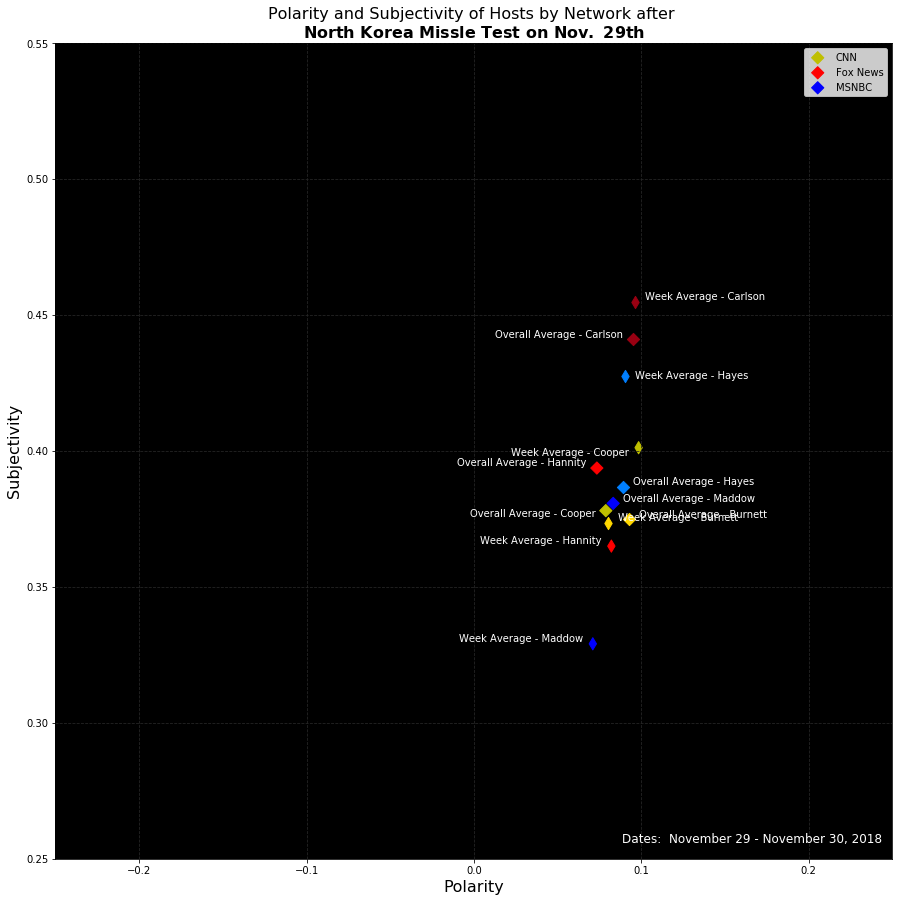

In [1440]:

plt.figure(figsize = (15,15))

# plt.scatter(ac_pol, ac_sub, color = 'yellow')
# plt.scatter(h_pol, h_sub, color = 'red')
# plt.scatter(rm_pol, rm_sub, color = 'b0')
# plt.scatter(tc_pol, tc_sub, color = '#990012')
# plt.scatter(ch_pol, ch_sub, color = '#007FFF')
# plt.scatter(ebo_pol, ebo_sub, color = 'gold')

#Overall Averages
plt.scatter(ac_mean_pol, ac_mean_sub, color = 'y0', s = 75, marker = 'D')
plt.annotate(s = 'Overall Average - Cooper', xy = (ac_mean_pol,ac_mean_sub), color = 'white',\
             xytext = (-10,2),textcoords='offset points', ha='right', va='top')
plt.scatter(h_mean_pol, h_mean_sub, color = 'r0', s = 75, marker = 'D')
plt.annotate(s = 'Overall Average - Hannity', xy = (h_mean_pol, h_mean_sub), color = 'white',\
             xytext = (-10,0),textcoords='offset points', ha='right', va='bottom')
plt.scatter(rm_mean_pol, rm_mean_sub, color = 'b0', s = 75, marker = 'D')
plt.annotate(s = 'Overall Average - Maddow', xy = (rm_mean_pol, rm_mean_sub), color = 'white',\
             xytext = (10,0),textcoords='offset points', ha='left', va='bottom')
plt.scatter(ch_mean_pol, ch_mean_sub, color = '#007FFF', s = 75, marker = 'D')
plt.annotate(s = 'Overall Average - Hayes', xy = (ch_mean_pol, ch_mean_sub), color = 'white',\
             xytext = (10,0),textcoords='offset points', ha='left', va='bottom')
plt.scatter(tc_mean_pol, tc_mean_sub, color = '#990012', s = 75, marker = 'D')
plt.annotate(s = 'Overall Average - Carlson', xy = (tc_mean_pol, tc_mean_sub), color = 'white',\
             xytext = (-10,0),textcoords='offset points', ha='right', va='bottom')
plt.scatter(ebo_mean_pol, ebo_mean_sub, color = 'gold', s = 75, marker = 'D')
plt.annotate(s = 'Overall Average - Burnett', xy = (ebo_mean_pol,ebo_mean_sub), color = 'white',\
             xytext = (10,0),textcoords='offset points', ha='left', va='bottom')

#Time Period Averages
plt.scatter(np.mean(ac_pol),np.mean(ac_sub), color = 'y0', s = 75, marker = 'd')
plt.annotate(s = 'Week Average - Cooper', xy = (np.mean(ac_pol),np.mean(ac_sub)), color = 'white',\
             xytext = (-10,0),textcoords='offset points', ha='right', va='top')
plt.scatter(np.mean(h_pol), np.mean(h_sub), color = 'r0', s = 75, marker = 'd')
plt.annotate(s = 'Week Average - Hannity', xy = (np.mean(h_pol), np.mean(h_sub)), color = 'white',\
             xytext = (-10,0),textcoords='offset points', ha='right', va='bottom')
plt.scatter(np.mean(rm_pol), np.mean(rm_sub), color = 'b0', s = 75, marker = 'd')
plt.annotate(s = 'Week Average - Maddow', xy = (np.mean(rm_pol), np.mean(rm_sub)), color = 'white',\
             xytext = (-10,0),textcoords='offset points', ha='right', va='bottom')
plt.scatter(np.mean(ch_pol), np.mean(ch_sub), color = '#007FFF', s = 75, marker = 'd')
plt.annotate(s = 'Week Average - Hayes', xy = (np.mean(ch_pol), np.mean(ch_sub)), color = 'white',\
             xytext = (10,-5),textcoords='offset points', ha='left', va='bottom')
plt.scatter(np.mean(tc_pol), np.mean(tc_sub), color = '#990012', s = 75, marker = 'd')
plt.annotate(s = 'Week Average - Carlson', xy = (np.mean(tc_pol), np.mean(tc_sub)), color = 'white',\
             xytext = (10,0),textcoords='offset points', ha='left', va='bottom')
plt.scatter(np.mean(ebo_pol),np.mean(ebo_sub), color = 'gold', s = 75, marker = 'd')
plt.annotate(s = 'Week Average - Burnett', xy = (np.mean(ebo_pol),np.mean(ebo_sub)), color = 'white',\
             xytext = (10,0),textcoords='offset points', ha='left', va='bottom')
plt.xlabel('Polarity', fontsize = 16)
plt.ylabel('Subjectivity', fontsize = 16)
plt.legend(['CNN', 'Fox News','MSNBC'], loc = 'best' )
plt.ylim(.25,.55)
plt.xlim((-.25,.25))
ax = plt.gca()
ax.set_facecolor('black')
plt.grid(color = '.15', linestyle = '--')
plt.title('Polarity and Subjectivity of Hosts by Network after \n' + r"$\bf{" + str("North\ Korea\ Missle\ Test\ on\ Nov.\ 29th") + "}$", fontsize = 16)
plt.figtext(.89, .14, "Dates:  November 29 - November 30, 2018", color = 'white', fontsize = 12, ha = 'right')
# plt.savefig('Images/PolSub_NorthKoreaMissleTest_Textblob.jpg');

In [164]:
analyzer = SentimentIntensityAnalyzer()
ac_date_holder = []
ac_pos_holder = []
ac_neg_holder = []
for date, sentence in zip(df_ac['Date'],df_ac['Commentator_Only']):
    vs = analyzer.polarity_scores(sentence)
    if len(sentence) > 5000:
        ac_date_holder.append(date)
        ac_pos_holder.append(vs['pos'])
        ac_neg_holder.append(vs['neg'])
    print("{}: {}. Content = {}".format(date, str(vs), len(sentence)))
ebo_date_holder = []
ebo_pos_holder = []
ebo_neg_holder = []
for date, sentence in zip(df_ebo['Date'],df_ebo['Commentator_Only']):
    vs = analyzer.polarity_scores(sentence)
    if len(sentence) > 5000:
        ebo_date_holder.append(date)
        ebo_pos_holder.append(vs['pos'])
        ebo_neg_holder.append(vs['neg'])
    print("{}: {}. Content = {}".format(date, str(vs), len(sentence)))
rm_date_holder = []
rm_pos_holder = []
rm_neg_holder = []
for date, sentence in zip(df_rm['Date'].drop_duplicates(),df_rm['Commentator_Only'].drop_duplicates()):
    vs = analyzer.polarity_scores(sentence)
    if len(sentence) > 5000:
        rm_date_holder.append(date)
        rm_pos_holder.append(vs['pos'])
        rm_neg_holder.append(vs['neg'])
    print("{}: {}. Content = {}".format(date, str(vs), len(sentence)))
ch_date_holder = []
ch_pos_holder = []
ch_neg_holder = []
for date, sentence in zip(df_ch['Date'].drop_duplicates(),df_ch['Commentator_Only'].drop_duplicates()):
    vs = analyzer.polarity_scores(sentence)
    if len(sentence) > 5000:
        ch_date_holder.append(date)
        ch_pos_holder.append(vs['pos'])
        ch_neg_holder.append(vs['neg'])
    print("{}: {}. Content = {}".format(date, str(vs), len(sentence)))
h_date_holder = []
h_pos_holder = []
h_neg_holder = []
for date, sentence in zip(df_h['Date'],df_h['Commentator_Only']):
    vs = analyzer.polarity_scores(sentence)
    if len(sentence) > 5000:
        h_date_holder.append(date)
        h_pos_holder.append(vs['pos'])
        h_neg_holder.append(vs['neg'])
    print("{}: {}. Content = {}".format(date, str(vs), len(sentence)))
tc_date_holder = []
tc_pos_holder = []
tc_neg_holder = []
for date, sentence in zip(df_tc['Date'],df_tc['Commentator_Only']):
    vs = analyzer.polarity_scores(sentence)
    if len(sentence) > 5000:
        tc_date_holder.append(date)
        tc_pos_holder.append(vs['pos'])
        tc_neg_holder.append(vs['neg'])
    print("{}: {}. Content = {}".format(date, str(vs), len(sentence)))

2018-02-19 00:00:00: {'neg': 0.099, 'neu': 0.837, 'pos': 0.063, 'compound': -0.9988}. Content = 19309
2018-02-16 00:00:00: {'neg': 0.077, 'neu': 0.835, 'pos': 0.088, 'compound': 0.9956}. Content = 28162
2018-02-15 00:00:00: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}. Content = 11
2018-02-14 00:00:00: {'neg': 0.081, 'neu': 0.83, 'pos': 0.089, 'compound': 0.9915}. Content = 31164
2018-02-13 00:00:00: {'neg': 0.061, 'neu': 0.855, 'pos': 0.084, 'compound': 0.9971}. Content = 16978
2018-02-12 00:00:00: {'neg': 0.107, 'neu': 0.788, 'pos': 0.106, 'compound': -0.9456}. Content = 26057
2018-02-09 00:00:00: {'neg': 0.062, 'neu': 0.834, 'pos': 0.104, 'compound': 0.999}. Content = 17104
2018-02-08 00:00:00: {'neg': 0.071, 'neu': 0.845, 'pos': 0.084, 'compound': 0.9788}. Content = 13879
2018-02-07 00:00:00: {'neg': 0.056, 'neu': 0.851, 'pos': 0.094, 'compound': 0.9984}. Content = 14885
2018-02-06 00:00:00: {'neg': 0.072, 'neu': 0.839, 'pos': 0.09, 'compound': 0.9934}. Content = 12611
201

2017-10-05 00:00:00: {'neg': 0.083, 'neu': 0.771, 'pos': 0.146, 'compound': 0.9998}. Content = 23291
2017-10-04 00:00:00: {'neg': 0.114, 'neu': 0.761, 'pos': 0.125, 'compound': 0.9914}. Content = 23128
2017-10-03 00:00:00: {'neg': 0.084, 'neu': 0.788, 'pos': 0.128, 'compound': 0.9994}. Content = 19736
2017-10-02 00:00:00: {'neg': 0.143, 'neu': 0.738, 'pos': 0.12, 'compound': -0.9993}. Content = 21381
2017-09-29 00:00:00: {'neg': 0.074, 'neu': 0.79, 'pos': 0.136, 'compound': 0.9997}. Content = 19763
2017-09-28 00:00:00: {'neg': 0.034, 'neu': 0.875, 'pos': 0.091, 'compound': 0.9993}. Content = 18902
2017-09-27 00:00:00: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}. Content = 5
2017-09-26 00:00:00: {'neg': 0.093, 'neu': 0.796, 'pos': 0.112, 'compound': 0.9937}. Content = 22924
2017-09-25 00:00:00: {'neg': 0.071, 'neu': 0.852, 'pos': 0.078, 'compound': 0.9791}. Content = 18401
2017-09-22 00:00:00: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}. Content = 5
2017-09-21 00:00:

2017-05-11 00:00:00: {'neg': 0.127, 'neu': 0.782, 'pos': 0.091, 'compound': -0.9994}. Content = 19893
2017-05-10 00:00:00: {'neg': 0.131, 'neu': 0.77, 'pos': 0.099, 'compound': -0.9988}. Content = 15462
2017-05-09 00:00:00: {'neg': 0.088, 'neu': 0.818, 'pos': 0.094, 'compound': 0.9818}. Content = 26285
2017-05-08 00:00:00: {'neg': 0.082, 'neu': 0.791, 'pos': 0.127, 'compound': 0.9995}. Content = 21951
2017-05-04 00:00:00: {'neg': 0.08, 'neu': 0.826, 'pos': 0.094, 'compound': 0.9934}. Content = 22325
2017-05-03 00:00:00: {'neg': 0.086, 'neu': 0.769, 'pos': 0.144, 'compound': 0.9997}. Content = 21361
2017-05-01 00:00:00: {'neg': 0.079, 'neu': 0.811, 'pos': 0.11, 'compound': 0.9985}. Content = 16922
2017-04-28 00:00:00: {'neg': 0.069, 'neu': 0.835, 'pos': 0.096, 'compound': 0.999}. Content = 22205
2017-04-27 00:00:00: {'neg': 0.088, 'neu': 0.777, 'pos': 0.136, 'compound': 0.9996}. Content = 20387
2017-04-26 00:00:00: {'neg': 0.069, 'neu': 0.813, 'pos': 0.119, 'compound': 0.9996}. Content 

2017-12-22 00:00:00: {'neg': 0.113, 'neu': 0.767, 'pos': 0.121, 'compound': 0.9929}. Content = 21837
2017-12-21 00:00:00: {'neg': 0.115, 'neu': 0.757, 'pos': 0.128, 'compound': 0.9733}. Content = 21647
2017-12-20 00:00:00: {'neg': 0.11, 'neu': 0.769, 'pos': 0.12, 'compound': 0.9789}. Content = 23251
2017-12-19 00:00:00: {'neg': 0.091, 'neu': 0.805, 'pos': 0.104, 'compound': 0.945}. Content = 13455
2017-12-18 00:00:00: {'neg': 0.107, 'neu': 0.78, 'pos': 0.114, 'compound': 0.9438}. Content = 14235
2017-12-15 00:00:00: {'neg': 0.095, 'neu': 0.769, 'pos': 0.136, 'compound': 0.9984}. Content = 11634
2017-12-14 00:00:00: {'neg': 0.111, 'neu': 0.795, 'pos': 0.094, 'compound': -0.9961}. Content = 13361
2017-12-13 00:00:00: {'neg': 0.109, 'neu': 0.769, 'pos': 0.122, 'compound': 0.9883}. Content = 14433
2017-12-12 00:00:00: {'neg': 0.121, 'neu': 0.761, 'pos': 0.118, 'compound': -0.9882}. Content = 20138
2017-12-11 00:00:00: {'neg': 0.118, 'neu': 0.786, 'pos': 0.096, 'compound': -0.998}. Content 

2017-08-25 00:00:00: {'neg': 0.106, 'neu': 0.774, 'pos': 0.121, 'compound': 0.9863}. Content = 14867
2017-08-24 00:00:00: {'neg': 0.107, 'neu': 0.768, 'pos': 0.125, 'compound': 0.9989}. Content = 25562
2017-08-23 00:00:00: {'neg': 0.115, 'neu': 0.763, 'pos': 0.121, 'compound': 0.9391}. Content = 21060
2017-08-22 00:00:00: {'neg': 0.141, 'neu': 0.739, 'pos': 0.119, 'compound': -0.9988}. Content = 22099
2017-08-18 00:00:00: {'neg': 0.13, 'neu': 0.767, 'pos': 0.102, 'compound': -0.9972}. Content = 11566
2017-08-17 00:00:00: {'neg': 0.171, 'neu': 0.728, 'pos': 0.101, 'compound': -0.9998}. Content = 15551
2017-08-16 00:00:00: {'neg': 0.114, 'neu': 0.728, 'pos': 0.157, 'compound': 0.9994}. Content = 19826
2017-08-15 00:00:00: {'neg': 0.128, 'neu': 0.758, 'pos': 0.114, 'compound': -0.9984}. Content = 21818
2017-08-14 00:00:00: {'neg': 0.107, 'neu': 0.774, 'pos': 0.119, 'compound': 0.9955}. Content = 19194
2017-08-11 00:00:00: {'neg': 0.127, 'neu': 0.734, 'pos': 0.139, 'compound': 0.4067}. Con

2017-04-28 00:00:00: {'neg': 0.118, 'neu': 0.753, 'pos': 0.129, 'compound': 0.9951}. Content = 17952
2017-04-27 00:00:00: {'neg': 0.092, 'neu': 0.792, 'pos': 0.116, 'compound': 0.9976}. Content = 20918
2017-04-26 00:00:00: {'neg': 0.093, 'neu': 0.796, 'pos': 0.111, 'compound': 0.9952}. Content = 21539
2017-04-25 00:00:00: {'neg': 0.115, 'neu': 0.773, 'pos': 0.113, 'compound': -0.9824}. Content = 22277
2017-04-24 00:00:00: {'neg': 0.104, 'neu': 0.757, 'pos': 0.139, 'compound': 0.9989}. Content = 14803
2017-04-22 00:00:00: {'neg': 0.134, 'neu': 0.764, 'pos': 0.102, 'compound': -0.999}. Content = 15627
2017-04-21 00:00:00: {'neg': 0.107, 'neu': 0.742, 'pos': 0.151, 'compound': 0.999}. Content = 14923
2017-04-20 00:00:00: {'neg': 0.103, 'neu': 0.759, 'pos': 0.137, 'compound': 0.9981}. Content = 17222
2017-04-19 00:00:00: {'neg': 0.104, 'neu': 0.76, 'pos': 0.136, 'compound': 0.998}. Content = 14029
2017-04-18 00:00:00: {'neg': 0.13, 'neu': 0.762, 'pos': 0.108, 'compound': -0.999}. Content =

In [476]:
rm_date_holder = []
rm_pos_holder = []
rm_neg_holder = []
for date, sentence in zip(df_rm['Date'].drop_duplicates(),df_rm['Commentator_Only'].drop_duplicates()):
    vs = analyzer.polarity_scores(sentence)
    if len(sentence) > 5000:
        rm_date_holder.append(date)
        rm_pos_holder.append(vs['pos'])
        rm_neg_holder.append(vs['neg'])
    print("{}: {}. Content = {}".format(date, str(vs), len(sentence)))

2016-01-29 00:00:00: {'neg': 0.056, 'neu': 0.858, 'pos': 0.086, 'compound': 0.9996}. Content = 31050
2016-01-28 00:00:00: {'neg': 0.063, 'neu': 0.851, 'pos': 0.086, 'compound': 0.9993}. Content = 29511
2016-01-27 00:00:00: {'neg': 0.075, 'neu': 0.83, 'pos': 0.095, 'compound': 0.9847}. Content = 17118
2016-01-26 00:00:00: {'neg': 0.05, 'neu': 0.852, 'pos': 0.098, 'compound': 0.9998}. Content = 27781
2016-01-25 00:00:00: {'neg': 0.058, 'neu': 0.852, 'pos': 0.09, 'compound': 0.9996}. Content = 29641
2016-01-22 00:00:00: {'neg': 0.051, 'neu': 0.846, 'pos': 0.103, 'compound': 0.9998}. Content = 31891
2016-01-20 00:00:00: {'neg': 0.063, 'neu': 0.833, 'pos': 0.104, 'compound': 0.9997}. Content = 31882
2016-01-19 00:00:00: {'neg': 0.086, 'neu': 0.834, 'pos': 0.081, 'compound': -0.9926}. Content = 26850
2016-01-18 00:00:00: {'neg': 0.056, 'neu': 0.83, 'pos': 0.114, 'compound': 0.9998}. Content = 25304
2016-01-15 00:00:00: {'neg': 0.07, 'neu': 0.816, 'pos': 0.114, 'compound': 0.9997}. Content = 

2016-06-27 00:00:00: {'neg': 0.048, 'neu': 0.8, 'pos': 0.152, 'compound': 1.0}. Content = 31925
2016-06-24 00:00:00: {'neg': 0.11, 'neu': 0.814, 'pos': 0.076, 'compound': -0.9995}. Content = 27445
2016-06-23 00:00:00: {'neg': 0.049, 'neu': 0.822, 'pos': 0.129, 'compound': 0.9999}. Content = 21134
2016-06-22 00:00:00: {'neg': 0.048, 'neu': 0.899, 'pos': 0.053, 'compound': 0.993}. Content = 24695
2016-06-21 00:00:00: {'neg': 0.06, 'neu': 0.837, 'pos': 0.104, 'compound': 0.9998}. Content = 32838
2016-06-20 00:00:00: {'neg': 0.073, 'neu': 0.816, 'pos': 0.111, 'compound': 0.9998}. Content = 37351
2016-06-17 00:00:00: {'neg': 0.118, 'neu': 0.796, 'pos': 0.086, 'compound': -0.9998}. Content = 30104
2016-06-15 00:00:00: {'neg': 0.057, 'neu': 0.818, 'pos': 0.126, 'compound': 0.9999}. Content = 31153
2016-06-14 00:00:00: {'neg': 0.155, 'neu': 0.777, 'pos': 0.068, 'compound': -0.9999}. Content = 24293
2016-06-13 00:00:00: {'neg': 0.15, 'neu': 0.769, 'pos': 0.08, 'compound': -0.9999}. Content = 28

2016-11-11 00:00:00: {'neg': 0.073, 'neu': 0.83, 'pos': 0.097, 'compound': 0.9994}. Content = 36719
2016-11-10 00:00:00: {'neg': 0.058, 'neu': 0.842, 'pos': 0.1, 'compound': 0.9997}. Content = 30403
2016-11-09 00:00:00: {'neg': 0.068, 'neu': 0.802, 'pos': 0.13, 'compound': 0.9999}. Content = 27356
2016-11-07 00:00:00: {'neg': 0.048, 'neu': 0.862, 'pos': 0.09, 'compound': 0.7998}. Content = 1280
2016-11-06 00:00:00: {'neg': 0.037, 'neu': 0.884, 'pos': 0.079, 'compound': 0.4124}. Content = 467
2016-11-04 00:00:00: {'neg': 0.043, 'neu': 0.847, 'pos': 0.111, 'compound': 0.9612}. Content = 1797
2016-11-03 00:00:00: {'neg': 0.073, 'neu': 0.805, 'pos': 0.121, 'compound': 0.9997}. Content = 25261
2016-11-02 00:00:00: {'neg': 0.05, 'neu': 0.85, 'pos': 0.101, 'compound': 0.9996}. Content = 21352
2016-11-01 00:00:00: {'neg': 0.109, 'neu': 0.807, 'pos': 0.084, 'compound': -0.999}. Content = 18812
2016-12-29 00:00:00: {'neg': 0.094, 'neu': 0.823, 'pos': 0.083, 'compound': -0.9785}. Content = 9717
2

2017-03-13 00:00:00: {'neg': 0.075, 'neu': 0.83, 'pos': 0.096, 'compound': 0.9991}. Content = 32400
2017-03-10 00:00:00: {'neg': 0.074, 'neu': 0.829, 'pos': 0.096, 'compound': 0.9993}. Content = 41222
2017-03-09 00:00:00: {'neg': 0.061, 'neu': 0.862, 'pos': 0.077, 'compound': 0.9972}. Content = 30784
2017-03-08 00:00:00: {'neg': 0.053, 'neu': 0.835, 'pos': 0.112, 'compound': 0.9999}. Content = 37056
2017-03-07 00:00:00: {'neg': 0.061, 'neu': 0.855, 'pos': 0.085, 'compound': 0.9994}. Content = 35109
2017-03-06 00:00:00: {'neg': 0.065, 'neu': 0.818, 'pos': 0.117, 'compound': 0.9999}. Content = 35879
2017-03-03 00:00:00: {'neg': 0.078, 'neu': 0.826, 'pos': 0.096, 'compound': 0.999}. Content = 35360
2017-03-02 00:00:00: {'neg': 0.071, 'neu': 0.855, 'pos': 0.075, 'compound': 0.9684}. Content = 25005
2017-04-28 00:00:00: {'neg': 0.088, 'neu': 0.811, 'pos': 0.101, 'compound': 0.9915}. Content = 29129
2017-04-27 00:00:00: {'neg': 0.059, 'neu': 0.848, 'pos': 0.093, 'compound': 0.9995}. Content 

2017-07-11 00:00:00: {'neg': 0.131, 'neu': 0.795, 'pos': 0.073, 'compound': -0.9999}. Content = 32806
2017-07-10 00:00:00: {'neg': 0.068, 'neu': 0.834, 'pos': 0.098, 'compound': 0.9993}. Content = 29585
2017-07-06 00:00:00: {'neg': 0.103, 'neu': 0.839, 'pos': 0.058, 'compound': -0.9995}. Content = 17188
2017-07-05 00:00:00: {'neg': 0.079, 'neu': 0.82, 'pos': 0.101, 'compound': 0.9973}. Content = 21654
2017-07-03 00:00:00: {'neg': 0.08, 'neu': 0.792, 'pos': 0.129, 'compound': 0.999}. Content = 13615
2017-08-31 00:00:00: {'neg': 0.075, 'neu': 0.832, 'pos': 0.094, 'compound': 0.9988}. Content = 31178
2017-08-30 00:00:00: {'neg': 0.081, 'neu': 0.808, 'pos': 0.111, 'compound': 0.999}. Content = 25091
2017-08-29 00:00:00: {'neg': 0.064, 'neu': 0.857, 'pos': 0.079, 'compound': 0.1363}. Content = 204
2017-08-28 00:00:00: {'neg': 0.08, 'neu': 0.812, 'pos': 0.107, 'compound': 0.9991}. Content = 21287
2017-08-25 00:00:00: {'neg': 0.029, 'neu': 0.882, 'pos': 0.089, 'compound': 0.999}. Content = 11

2017-11-06 00:00:00: {'neg': 0.051, 'neu': 0.819, 'pos': 0.129, 'compound': 0.9997}. Content = 15301
2017-11-03 00:00:00: {'neg': 0.065, 'neu': 0.837, 'pos': 0.098, 'compound': 0.9992}. Content = 23712
2017-11-02 00:00:00: {'neg': 0.087, 'neu': 0.797, 'pos': 0.116, 'compound': 0.9992}. Content = 24575
2017-11-01 00:00:00: {'neg': 0.072, 'neu': 0.813, 'pos': 0.115, 'compound': 0.9996}. Content = 24819
2017-12-28 00:00:00: {'neg': 0.057, 'neu': 0.852, 'pos': 0.091, 'compound': 0.9992}. Content = 23499
2017-12-27 00:00:00: {'neg': 0.082, 'neu': 0.834, 'pos': 0.084, 'compound': 0.9524}. Content = 27697
2017-12-26 00:00:00: {'neg': 0.036, 'neu': 0.871, 'pos': 0.093, 'compound': 0.9998}. Content = 26447
2017-12-21 00:00:00: {'neg': 0.038, 'neu': 0.891, 'pos': 0.071, 'compound': 0.9977}. Content = 14775
2017-12-20 00:00:00: {'neg': 0.069, 'neu': 0.841, 'pos': 0.09, 'compound': 0.9983}. Content = 25878
2017-12-19 00:00:00: {'neg': 0.039, 'neu': 0.837, 'pos': 0.124, 'compound': 1.0}. Content = 

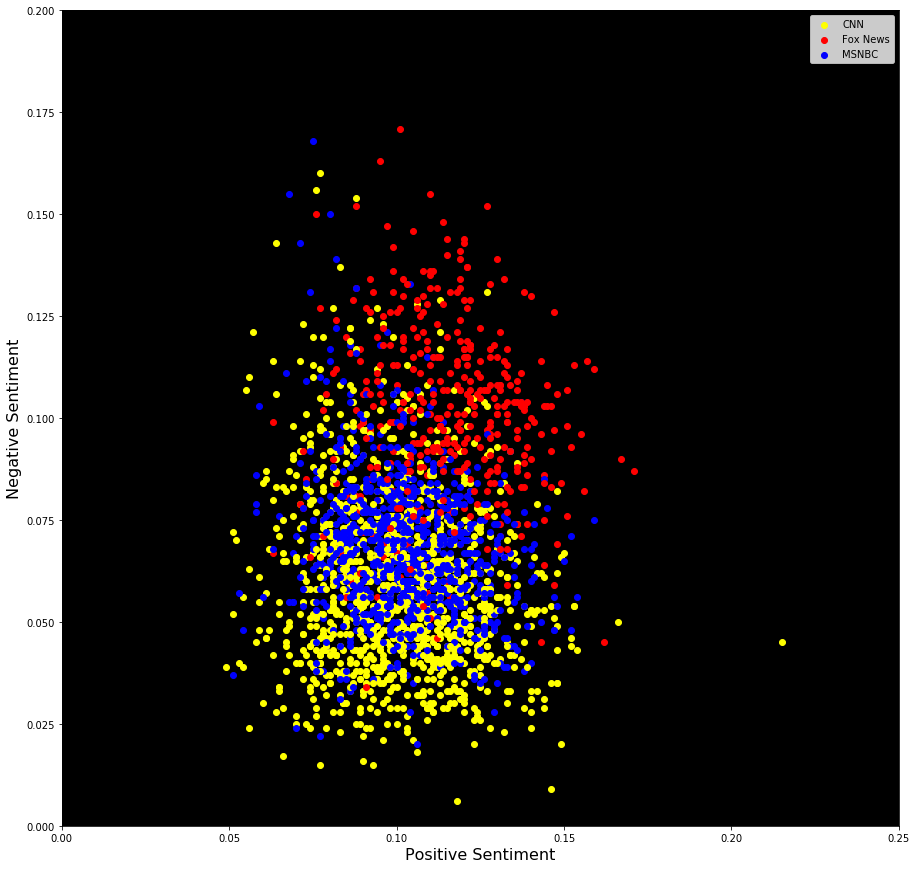

In [165]:
plt.figure(figsize = (15,15))
plt.scatter(ac_pos_holder, ac_neg_holder, color = 'yellow')
plt.scatter(h_pos_holder, h_neg_holder, color = 'red')
plt.scatter(rm_pos_holder, rm_neg_holder, color = 'blue')
plt.scatter(ebo_pos_holder, ebo_neg_holder, color = 'yellow')
plt.scatter(ch_pos_holder, ch_neg_holder, color = 'blue')
plt.scatter(tc_pos_holder, tc_neg_holder, color = 'red')
ax = plt.gca()
ax.set_facecolor('black')
plt.xlabel('Positive Sentiment',fontsize = 16)
plt.ylabel('Negative Sentiment',fontsize = 16)
# plt.title('VADER Sentiment Analysis of CNN, Fox News, and MSNBC Hosts', )
plt.legend(['CNN','Fox News','MSNBC'], loc='best')
plt.ylim((0,.2))
plt.xlim((0,.25))
plt.savefig('Images/VADERsentiment_all.jpg');

In [166]:
rm_pos_test = [list(x) for x in zip(*sorted(zip(rm_date_holder, rm_pos_holder), key=itemgetter(0)))]
rm_neg_test = [list(x) for x in zip(*sorted(zip(rm_date_holder, rm_neg_holder), key=itemgetter(0)))]
h_pos_test = [list(x) for x in zip(*sorted(zip(h_date_holder, h_pos_holder), key=itemgetter(0)))]
h_neg_test = [list(x) for x in zip(*sorted(zip(h_date_holder, h_neg_holder), key=itemgetter(0)))]
# tc_pos_test = [list(x) for x in zip(*sorted(zip(tc_date_holder, tc_pos_holder), key=itemgetter(0)))]
# tc_neg_test = [list(x) for x in zip(*sorted(zip(tc_date_holder, tc_neg_holder), key=itemgetter(0)))]
# ch_pos_test = [list(x) for x in zip(*sorted(zip(ch_date_holder, ch_pos_holder), key=itemgetter(0)))]
# ch_neg_test = [list(x) for x in zip(*sorted(zip(ch_date_holder, ch_neg_holder), key=itemgetter(0)))]
# ac_pos_test = [list(x) for x in zip(*sorted(zip(ac_date_holder, ac_pos_holder), key=itemgetter(0)))]
# ac_neg_test = [list(x) for x in zip(*sorted(zip(ac_date_holder, ac_neg_holder), key=itemgetter(0)))]

### 2017 through the sentiment of the cable news hosts

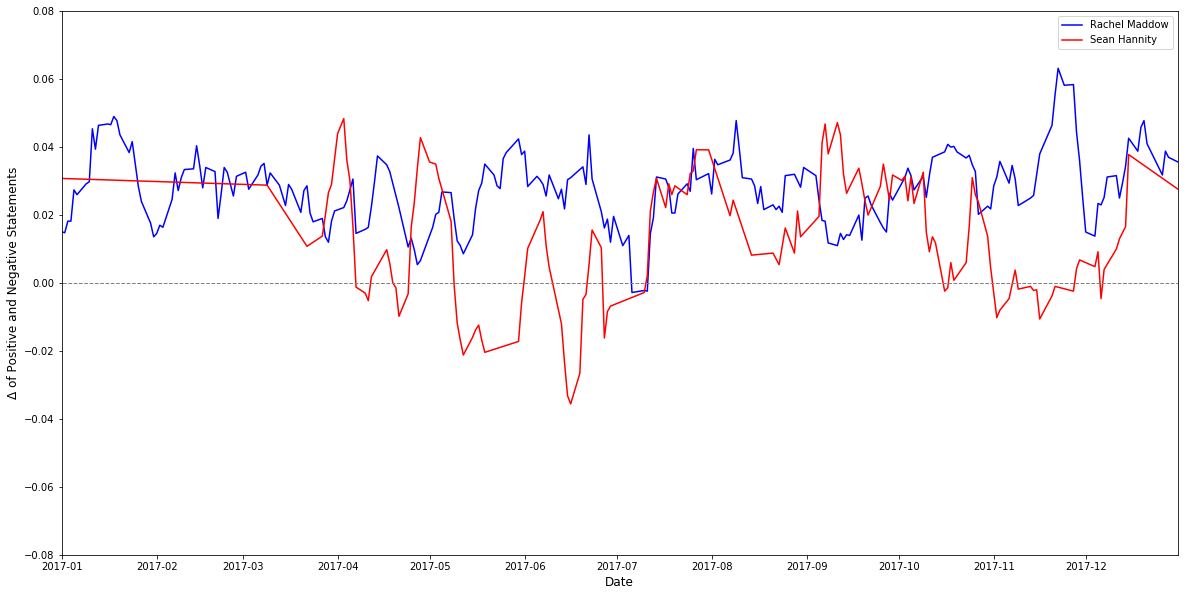

In [167]:
zero_line = [0 for x in range(432)]
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')
window = 5
plt.figure(figsize = (20,10))

# plt.plot(ac_date_holder, ac_pos_holder)
'''Rachel Maddow'''
y_av_pos = movingaverage(rm_pos_test[1], window)
# plt.plot(rm_pos_test[0], y_av_pos,color = "g")
y_av_neg = movingaverage(rm_neg_test[1], window)
plt.plot(rm_neg_test[0], (y_av_pos - y_av_neg),color = "blue")
'''Hannity'''
y_av_posh = movingaverage(h_pos_test[1], window)
# plt.plot(h_pos_test[0], y_av_posh,color = "b")
y_av_negh = movingaverage(h_neg_test[1], window)
plt.plot(h_neg_test[0],(y_av_posh - y_av_negh),color = "red")
'''Tucker Carlson'''
# y_av_postc = movingaverage(tc_pos_test[1], window)
# y_av_negtc = movingaverage(tc_neg_test[1], window)
# # plt.plot(tc_neg_test[0],(y_av_postc - y_av_negtc),color = "orange")
# '''Chris Hayes'''
# y_av_posch = movingaverage(ch_pos_test[1], window)
# y_av_negch = movingaverage(ch_neg_test[1], window)
# # plt.plot(ch_neg_test[0],(y_av_posch - y_av_negch),color = "aqua")
# '''Anderson Cooper'''
# y_av_posac = movingaverage(ac_pos_test[1], window)
# y_av_negac = movingaverage(ac_neg_test[1], window)
# plt.plot(ac_neg_test[0],(y_av_posac - y_av_negac),color = "gold")
plt.xlim(('2017-1-1', '2017-12-31'))
plt.ylim((-0.08,0.08))
plt.xlabel('Date', fontsize = 12)
plt.plot(rm_neg_test[0],zero_line, color = 'grey',linestyle = '--', linewidth=1)
plt.ylabel('Δ of Positive and Negative Statements', fontsize =12)
# plt.title('Comparing Rachel Maddow and Sean Hannity using VADER Sentiment Analysis and 7-day moving average', fontsize = 16)
plt.legend(['Rachel Maddow','Sean Hannity'],loc='best');
# plt.savefig('Images/VADERsentiment_maddow-vs-hannity_time2.jpg');

In [56]:
analyzer.polarity_scores('''
Thanks to you at home for joining us for the next hour.  What a day, huh? 

You have been seeing live images of a plane sitting on a tarmac now moving
down a taxiway in Los Angeles.  This is a private plane of some kind.  It`s
not unusual for federal agencies, especially big ones like the department
of justice or the FBI to have private planes at their disposal. 

 

Director Comey was in Los Angeles for, I think, what was supposed to be a
recruiting event today, an event that was canceled.  There was some
logistical question once he was fired today by the White House as to what
would physically happen to him in the immediate aftermath of his firing. 
He was removed effective immediately. 

 

So, right now, he is no longer the director of the FBI.  What we believe
that Director Comey is on that plane, which is now taxiing down the runway
in Los Angeles, presumably they`ll be flying back to the east coast,
presumably, the FBI headquarters in Washington.  He`ll be heading back to
Washington.

 

But all of this is unscripted at this point.  All of this is unprecedented. 
There are historical parallels to what happened today, but there`s never
been anything like this before.  One instance previously in U.S. history in
which an FBI director has been fired by as president. 
That was a very different circumstance.  

It was President Bill Clinton at the time.  The FBI director who was fired was William Sessions.  There
were, in effect, abuse of office concerns that had been documented against him by the Department of Justice.  Things like using a Department of

Justice aircraft to fly to see his family.  Things like using department

resources to build a fence around his house that didn`t seem to have any

security purpose.  And maybe was just because he wanted a fence at this

house. 

 

Those kind of concerns that led to Sessions leaving.  William sessions

being fired by president Clinton in the `90s.  That`s the only precedent

we`ve got for an FBI director being fired. 

 

We`re left as we watch these remarkable scenes and we wonder what`s going

to happen next here with James Comey – we`re left to find other context,

other analogies that make this make sense. 

 

In 1972, there was a tape made in the Oval Office.  It was made on June

23rd, 1972.  In that tape, the then-President of the United States, Richard

Nixon, and his chief of staff, H.R. Halderman, they talked about how they

would cover up what they knew about the Watergate break-in, which the Nixon

administration had orchestrated.  And there they were on tape talking about

how to beat the investigation into it, how to cover it up. 

 

And that tape was released to the public on August 5th, 1974.  The Supreme

Court had ordered the president to release that tape and ultimately, he

relented and released that tape. 

 

By then, by the time that Watergate tape, that Oval Office tape was

released, the Watergate scandal was quite ripe.  Impeachment proceedings

were well under way already.  There were 11 Republicans on the House

Judiciary Committee who voted against impeaching Richard Nixon. 

 

But when that tape came out, that August, all of the 11 Republicans on that

judiciary committee had said they would not impeach Nixon.  They all said

hearing that tape, that they would change their votes.  That they would

vote to impeach. 
''')

{'compound': 0.9547, 'neg': 0.056, 'neu': 0.857, 'pos': 0.087}

In [55]:
analyzer.polarity_scores('''
But first, kicking Comey to the curb! This is the first step in President Trump draining the deep state swamp. And that is tonight's and perhaps my most important "Opening Monologue" ever.
And welcome back to "Hannity."
All right, we're going to cut through all of the noise, all of the nonsense on this program tonight and tell you exactly what the left and destroy Trump media will not tell you.
James Comey, the former now FBI director, is a national embarrassment. It's that plain, it's that simple. And frankly, he's very lucky that President Trump kept him around this long because of his now unhinged and very erratic behavior.
Now, firing James Comey was absolutely the single right thing for this president to do. It's good for the country, and let me tell you why.
Comey has failed you, the American people, on a spectacular level! And at every single turn, the FBI director disrespected the Constitution, he showed he does not care about the equal application of the rule of law being applied equally American. He has now stood by while our 4th Amendment rights have been trampled upon. And worst of all, he has created in this country how a two-tiered justice system, one for Hillary and Bill Clinton, and one for the rest of America. It's become a travesty. Comey tonight should be ashamed of himself.  
Now, let's start with facts, and Hillary Clinton and the private email server that she used purposely to circumvent what is known as congressional oversight. Here are the facts, plain and simple. Hillary Clinton's server contained top-secret special access programs -- in other words, the highest level of classified information on her computer. She deleted over 30,000 emails on that computer, claiming they were personal. They were about yoga, weddings, grandchildren and emailing Bill Clinton, who never had an email account. This was a lie from the get-go.

And what's so despicable about this is back in July, when Comey made his big announcement on Hillary Clinton and the investigation, he acknowledged all of these facts, which, by the way, is an acknowledgment that crimes were committed!
''')

{'compound': -0.9327, 'neg': 0.088, 'neu': 0.857, 'pos': 0.055}

First Divergence (April):
* Trump removes Steve Bannon from National Security Council
* Tax Day Protests
* Trump meets with Chinese President Xi JinPing
* North Korea Standoff
* Sean Spicer makes remarks comparing Syria and Hitler
* Berkeley Protests and clashes between Antifa and Alt-Right Supporters

Second Divergence (May - June):
* Trump fires James Comey (May 9)
* DOJ appoints Robert Mueller (May 17)
* Allegations Trump gave the Russian ambassador confidential information

Third Divergence (September - October):
* DHS stops taking applications for DACA (September 5)
* Trump makes speech at UN condemning 'Rocket Man' (September 19)
* Department of Education announces rollback of Title IX protections (September 7)
* DOJ argues businesses have constitutional right to discriminate on basis of sexual orientation (September 7)

Fourth Divergence (October - December): 
* Las Vegas Shooting
* Pence walks out of NFL football game on October 8
* Trump removes requirements of ACA 
* US withdraws from UNESCO (October 12)
* Trump says he won't certify Iran Deal (October 13)
* Indictments of Rick Gates, Paul Manafort, and George Papadopoulos (October 30)
* Terror attack in NYC (October 31)
* Tax Bill is introduced
* Roy Moore allegations of sexual misconduct start (November 9)
* Flynn pleads guilty (December 1)

In [76]:
print(df_rm[df_rm.Date == '2017-11-20']['Content'][412])

Transcript:
Show: THE RACHEL MADDOW SHOW
Date: November 20, 2017
Guest: Paul Rosenzweig, Shannon Pettypiece

CHRIS HAYES, MSNBC HOST, ALL IN: That is “ALL IN” for this evening.
THE RACHEL MADDOW SHOW starts right now.
Good evening, Rachel.
RACHEL MADDOW, MSNBC HOST: You know, you get what you paid for in terms of
your political consulting. You`re getting it for free on TV.
HAYES: That`s exactly right. Yes. Not what you want to lead with on the
yard signs in America.
UNIDENTIFIED MALE: You watch Rachel Maddow. I watch Rachel Maddow. Vote
for me.
HAYES: Defends on the district.
MADDOW: Yes, that`s worked for absolutely everyone who`s ever around on
that one.
(LAUGHTER)
MADDOW: Thanks, my friend.
And thanks to you at home for joining us this hour.
Wow. So, this has been an incredible and fast-moving day of news. I sort
of think like the news gods are looking ahead and thinking all right,
Thursday`s a holiday, for Thanksgiving, we`d better get moving because
we`ve got a lot to cram into wh

In [100]:
#What days was Rachel Maddow very positive?
pd.DataFrame(rm_date_holder,list(rm_pos_holder)).reset_index().sort_values('index', ascending=False).head(10)

,index,0
133,0.154,2016-10-28
81,0.152,2016-06-27
66,0.146,2016-05-20
35,0.144,2016-03-30
26,0.143,2016-02-15
75,0.143,2016-05-06
20,0.140,2016-02-24
149,0.140,2016-11-29
117,0.140,2016-09-29
23,0.138,2016-02-19


In [101]:
#What days was Rachel Maddow very negative?
pd.DataFrame(rm_date_holder,list(rm_neg_holder)).reset_index().sort_values('index', ascending=False).head(10)

,index,0
80,0.168,2016-06-28
89,0.155,2016-06-14
90,0.150,2016-06-13
40,0.143,2016-03-22
318,0.131,2017-07-11
87,0.118,2016-06-17
257,0.114,2017-04-11
422,0.112,2018-01-31
82,0.110,2016-06-24
164,0.109,2016-11-01


### Topic Modeling

In [135]:
hannity_test = df_h[(df_h.Date >= '2017-5-1') & (df_h.Date <= '2018-2-1')]['Commentator_Only'].values
maddow_test = df_rm[(df_rm.Date >= '2017-5-1') & (df_rm.Date <= '2018-2-1')]['Commentator_Only'].values
cooper_test = df_ac[(df_ac.Date >= '2017-5-1') & (df_ac.Date <= '2018-2-1')]['Commentator_Only'].values
carlson_test = df_tc[(df_tc.Date >= '2017-5-1') & (df_tc.Date <= '2018-2-1')]['Commentator_Only'].values
hayes_test = df_ch[(df_ch.Date >= '2017-5-1') & (df_ch.Date <= '2018-2-1')]['Commentator_Only'].values
burnett_test = df_ebo[(df_ebo.Date >= '2017-5-1') & (df_ebo.Date <= '2018-2-1')]['Commentator_Only'].values


In [153]:
df_fox = pd.concat([df_h,df_tc])
df_rest = pd.concat([df_rm,df_ac,df_ebo,df_ch])

In [154]:
fox_test = df_fox[(df_fox.Date >= '2017-5-1') & (df_fox.Date <= '2018-2-1')]['Commentator_Only'].values
rest_test = df_rest[(df_rest.Date >= '2017-5-1') & (df_rest.Date <= '2018-2-1')]['Commentator_Only'].values

In [155]:
df_fox.head()

,Commentator_Only,Content,Date,Network,Show,Title,URLs
0,"Hey, Tucker. Great show. And welcome to HANNI...","SEAN HANNITY, FOX NEWS HOST: Hey, Tucker. Grea...",2018-02-19,Fox News,Hannity,DOJ to probe potential Obama-era surveillance ...,http://www.foxnews.com/transcript/2018/02/19/d...
1,This is a Fox News alert. Welcome to the spec...,"SEAN HANNITY, HOST: This is a Fox News alert. ...",2018-02-16,Fox News,Hannity,Hannity: Examining key points from Russian ind...,http://www.foxnews.com/transcript/2018/02/16/h...
2,And welcome to HANNITY. And this is a Fox New...,SEAN HANNITY: And welcome to HANNITY. And this...,2018-02-15,Fox News,Hannity,Judge Jeanine: Our kids deserve our protection,http://www.foxnews.com/transcript/2018/02/15/j...
3,Welcome to HANNITY and this is a FOX News ale...,"SEAN HANNITY, FOX NEWS HOST: Welcome to HANNIT...",2018-02-14,Fox News,Hannity,Students describe Florida high school shooting...,http://www.foxnews.com/transcript/2018/02/14/s...
4,Welcome to HANNITY. We have a ton of new break...,Welcome to HANNITY.\nWe have a ton of new brea...,2018-02-13,Fox News,Hannity,Newt Gingrich on Obama officials under fire,http://www.foxnews.com/transcript/2018/02/13/n...


In [156]:
stoplist = ESW.union(
    frozenset(('guest', 'advertisement','sean','hannity','tucker',\
               'welcome','breaking','tonight','host','right','thank','monologue', 'babaganoosh', 'transcript',\
              'roy','paul','james','jeff','just','michael','that','like','it','.', ',', '(', ')', "'", '"','straight', 'ahead','Welcome back',\
         'ADVERTISEMENT','SEAN','HANNITY', 'HOST','BEGIN', 'VIDEO', 'CLIP','when','come','back','Hannity','joining',\
        'reaction','fox','news','contributor','tucker','carlson','tonight','good','evening','welcome','joins',\
        'liberty','mutual','insurance','jay','geraldo','outfront','said')))
tfidf_h = TfidfVectorizer(stop_words = stoplist)
tfidf_rm = TfidfVectorizer(stop_words = stoplist)
tfidf_ac = TfidfVectorizer(stop_words = stoplist)
tfidf_tc = TfidfVectorizer(stop_words = stoplist)
tfidf_ch = TfidfVectorizer(stop_words = stoplist)
tfidf_ebo = TfidfVectorizer(stop_words = stoplist)
tfidf_rest = TfidfVectorizer(stop_words = stoplist)
tfidf_fox = TfidfVectorizer(stop_words = stoplist)

In [160]:
# hannity_tfidf = tfidf_h.fit_transform(hannity_test)
# maddow_tfidf = tfidf_rm.fit_transform(maddow_test)
# cooper_tfidf = tfidf_ac.fit_transform(cooper_test)
# carlson_tfidf = tfidf_tc.fit_transform(carlson_test)
# hayes_tfidf = tfidf_ch.fit_transform(hayes_test)
# burnett_tfidf = tfidf_ebo.fit_transform(burnett_test)
rest_tfidf = tfidf_rest.fit_transform(rest_test)
fox_tfidf = tfidf_fox.fit_transform(fox_test)

In [179]:
components = 7
# model_hannity = NMF(n_components=components, init='random', random_state=0)
# doc_topics_hannity = model_hannity.fit_transform(hannity_tfidf)

# model_maddow = NMF(n_components=components, init='random', random_state=0)
# doc_topics_maddow = model_maddow.fit_transform(maddow_tfidf)

# model_cooper = NMF(n_components=components, init='random', random_state=0)
# doc_topics_cooper = model_cooper.fit_transform(cooper_tfidf)

# model_carlson = NMF(n_components=components, init='random', random_state=0)
# doc_topics_carlson = model_carlson.fit_transform(carlson_tfidf)

# model_hayes = NMF(n_components=components, init='random', random_state=0)
# doc_topics_hayes = model_hayes.fit_transform(hayes_tfidf)

# model_burnett = NMF(n_components=components, init='random', random_state=0)
# doc_topics_burnett = model_burnett.fit_transform(burnett_tfidf)

model_rest = NMF(n_components=components, init='random', random_state=0)
doc_topics_rest = model_rest.fit_transform(rest_tfidf)

model_fox = NMF(n_components=components, init='random', random_state=0)
doc_topics_fox = model_fox.fit_transform(fox_tfidf)

In [180]:
def display_topics(model, feature_names, no_top_words, list_name):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx +1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        list_name.append([", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])])
        print('')

In [184]:
topic_counts = 15

In [185]:
all_topics = []
display_topics(model_rest, tfidf_rest.get_feature_names(), topic_counts, all_topics)

Topic 1:
president trump people today house republican new senator thing republicans health senate tax going sort

Topic 2:
comey fbi president investigation director flynn memo house justice russia attorney mueller fired white trump

Topic 3:
moore alabama sexual women allegations tax jones doug race senate know franken accused president republican

Topic 4:
president mean know white house trump cnn people going saying david think today say senator

Topic 5:
trump meeting jr russian donald campaign know kushner russia mails manafort lawyer jared government information

Topic 6:
storm hurricane know irma people florida puerto rico water going miami keys mean island st

Topic 7:
korea north president nuclear guam trump kim threat jong missile threats korean military fury china



In [186]:
all_topics = []
display_topics(model_fox, tfidf_fox.get_feature_names(), topic_counts, all_topics)

Topic 1:
people don think say know trump lot did new president time saying going want question

Topic 2:
uranium clinton hillary russian russia nuclear informant bribery john deal evidence solomon dnc podesta scandal

Topic 3:
weinstein harvey hollywood women sexual nbc gutierrez harassment new bloom clinton theaters going scandal allegations

Topic 4:
president trump media destroy time people ll ve going seanhannity know left comey commercial break

Topic 5:
strzok fbi comey mueller investigation clinton trump hillary justice president mccabe information counsel special messages

Topic 6:
vegas paddock las shooting gun know stephen people guns mass don shooter eliquis authorities shootings

Topic 7:
people don think know immigration country immigrants say illegal question lot does daca google california



In [1004]:
hannity_topics = []
display_topics(model_hannity,tfidf_h.get_feature_names(),topic_counts, hannity_topics)

Topic 1:
president trump media know people comey think ve going don ll want way night let time look got destroy russia

Topic 2:
weinstein nfl hollywood anthem harvey flag players women going people want president know kaepernick money gutierrez polanski country kimmel national

Topic 3:
strzok trump mueller fbi president clinton investigation know hillary memo comey page fisa dossier people exoneration mccabe let fix peter

Topic 4:
vegas paddock shooting people gun las police know country guns tragedy don bless president mass celebrities victims hospital politicize lives

Topic 5:
hurricane florida storm texas irma people governor going know steve ve state ground mayor bastardi rick harrigan wind prayers joe

Topic 6:
franken sexual moore women clinton allegations misconduct conyers al years senator tweeden accusers people juanita hillary accused flowers lauer judge

Topic 7:
clinton uranium hillary russia russian dnc trump evidence putin fbi dossier knew know john media information 

In [995]:
maddow_topics = []
display_topics(model_maddow,tfidf_rm.get_feature_names(),topic_counts, maddow_topics)

Topic 1:
president trump mueller attorney white house general sessions counsel today know new campaign

Topic 2:
flynn mike trump russian campaign pence meeting government house transition russia security new

Topic 3:
fbi comey director investigation president justice trump house attorney memo fired know russia

Topic 4:
alabama moore republicans vote senator republican going senate health today democrats votes people

Topic 5:
dossier steele fusion trump simpson committee christopher gps russia senator glenn intelligence grassley

Topic 6:
isis manchester suicide bomber rukmini police attack venue helen pete people explosion zac

Topic 7:
facebook manafort puerto rico russian hurricane people trump storm russia campaign know today



In [1005]:
cooper_topics = []
display_topics(model_cooper,tfidf_ac.get_feature_names(),topic_counts, cooper_topics)

Topic 1:
jr trump donald meeting russian know mean campaign mails kushner russia president attorney government jared mail son clinton lawyer father

Topic 2:
korea north president nuclear guam threats mean threat military hertling korean china kim general rhetoric jong know marks mcconnell manafort

Topic 3:
comey president house fbi director white investigation mean flynn know russia mueller attorney general trump fired sessions memo yates special

Topic 4:
know mean people police shooting attack shooter vegas las terror going manchester hospital want cnn killer vehicle new investigation concert

Topic 5:
moore alabama sexual allegations president mean know women vote doug jones senate flynn senator think trump believe percent people judges

Topic 6:
president mean know white house trump today people senator bannon going think new saying kelly cnn charlottesville health ll time

Topic 7:
storm hurricane irma florida people island puerto rico st water miami know tom going mayor islands

In [997]:
carlson_topics = []
display_topics(model_carlson,tfidf_tc.get_feature_names(),topic_counts, carlson_topics)

Topic 1:
people don trump think president know say new time going did lot want

Topic 2:
fbi comey investigation strzok director trump president know clinton think flynn don government

Topic 3:
ms 13 sessions monday gang general weekend salvador balanced attorney el detainees states

Topic 4:
people don think know country immigration say immigrants question lot google illegal want

Topic 5:
symbicort memo people don doctor pain brilinta law state new camel think california

Topic 6:
weinstein harvey vegas know las don paddock nbc witness new perry women katy

Topic 7:
podesta uranium eliquis manafort russian gillespie campaign hillary clinton know group source brazile



In [958]:
hayes_topics = []
display_topics(model_hayes,tfidf_ch.get_feature_names(),topic_counts, hayes_topics)

Topic 1:
health care senate going president tax people republican senator house

Topic 2:
flynn president trump yates house know sanctions white security lied

Topic 3:
president trump white house people new today daca think know

Topic 4:
trump russian meeting jr know campaign president kushner russia manafort

Topic 5:
comey president fbi investigation house director white sessions trump justice

Topic 6:
moore alabama allegations tax president women trump jones accused race

Topic 7:
storm irma hurricane miami florida people beach sea houston going

Topic 8:
mueller president trump mccabe wynn investigation counsel fbi manafort robert

Topic 9:
puerto price rico people tom hhs gun vegas private las



In [959]:
burnett_topics = []
display_topics(model_burnett,tfidf_ebo.get_feature_names(),topic_counts, burnett_topics)

Topic 1:
trump jr meeting russian donald president lawyer know putin government

Topic 2:
vegas las shooter know hotel people shooting gunman room shot

Topic 3:
moore alabama women tax going sexual trump franken know accusers

Topic 4:
comey president jim know fbi tapes investigation trump director did

Topic 5:
president trump know kushner flynn jared russia investigation house congressman

Topic 6:
korea north president guam trump kim missile threat jong united

Topic 7:
storm florida irma hurricane know keys water going puerto people

Topic 8:
memo fbi nunes release president trump know investigation house shutdown

Topic 9:
president trump house know white bannon kelly today going people



### Count Vectorizer

In [514]:
from nltk.util import ngrams

from collections import Counter
from operator import itemgetter

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"','“','“','”','straight', 'ahead','Welcome back',\
         'ADVERTISEMENT','SEAN','HANNITY', 'HOST','BEGIN', 'VIDEO', 'CLIP','when','come','back','Hannity','joining',\
        'reaction','fox','news','contributor','tucker','carlson','tonight','good','evening','welcome','joins',\
        'liberty','mutual','insurance','jay','geraldo']
stop = set(stop)

counter = Counter()


for doc in burnett_test:
    words = TextBlob(doc).words  # tokenize words
    words = [w for w in words if w not in stop]   
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(30):
    print('%20s %i' % (" ".join(phrase), count))

     All right Thank 382
    right Thank much 344
   I appreciate time 238
president United States 175
           I want go 154
      thank much And 148
  President Trump 's 146
     Donald Trump Jr 146
     All right thank 127
          And I want 120
    right thank much 120
           Let 's go 116
           I 'm Erin 110
     'm Erin Burnett 110
      New York Times 109
          I 'm going 105
           I mean 's 104
          I want ask 102
         I want play 98
       much And next 98
        We 're going 97
      Thank much And 92
      All right Well 88
   much I appreciate 87
 The Washington Post 86
          I n't know 84
Erin Burnett OutFront 84
   And next breaking 82
          I 'm sorry 76
        right I mean 74


In [498]:
n = 3

In [510]:


counter = Counter()
# df_h[(df_ac.Date >= '2017-5-1') & (df_ac.Date <= '2018-2-1')]['Commentator_Only'].values
for doc in hannity_test:
    words = TextBlob(doc).words  # tokenize words
    words = [w for w in words if w not in stop]   
    bigrams = ngrams(words, 3)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(30):
    print('%20s %i' % (" ".join(phrase), count))

      New York Times 197
 destroy Trump media 170
  President Trump 's 131
  Hillary Clinton 's 120
        The New York 116
    Uranium One deal 106
          I n't know 103
          I 'm going 101
        We 're going 90
   equal justice law 75
     Donald Trump Jr 75
 The Washington Post 73
      Fox News Alert 72
       This Fox News 67
         I n't think 65
          You know I 64
           I 've got 64
          I think 's 63
  America 's uranium 61
 busy breaking night 57
         All right I 55
Russia Russia Russia 54
            I ca n't 52
 forgotten men women 52
          You ca n't 51
Debbie Wasserman Schultz 50
  20 percent America 50
  percent America 's 50
            And I 'm 49
 monologue All right 48


In [513]:


counter = Counter()
# df_h[(df_ac.Date >= '2017-5-1') & (df_ac.Date <= '2018-2-1')]['Commentator_Only'].values

for doc in carlson_test:
    words = TextBlob(doc).words  # tokenize words
    words = [w for w in words if w not in stop]   
    bigrams = ngrams(words, 3)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(30):
    print('%20s %i' % (" ".join(phrase), count))

      new york times 130
    us thanks coming 89
       new york city 76
  hillary clinton 's 74
   thanks lot coming 61
   sworn enemy lying 58
    tune every night 56
    show sworn enemy 51
    every night 8:00 51
enemy lying pomposity 47
lying pomposity smugness 43
        n't think 's 38
  president trump 's 37
  black lives matter 37
       us tune every 36
pomposity smugness groupthink 34
  see tomorrow night 33
president united states 31
     us thank coming 31
     8:00 show sworn 30
          's us tune 30
     night 8:00 show 30
         n't know 's 29
     radio show host 28
attorney general jeff 28
   200 booking sites 28
general jeff sessions 27
  prices 200 booking 27
tripadvisor latest reviews 27
latest reviews lowest 27


In [505]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"','“','“','”','straight', 'ahead','Welcome back',\
         'ADVERTISEMENT','SEAN','HANNITY', 'HOST','BEGIN', 'VIDEO', 'CLIP','when','come','back','Hannity','joining',\
        'reaction','fox','news','contributor','tucker','carlson','tonight','good','evening','welcome','joins',\
        'liberty','mutual','insurance','jay','geraldo']
stop = set(stop)

counter = Counter()
# df_h[(df_ac.Date >= '2017-5-1') & (df_ac.Date <= '2018-2-1')]['Commentator_Only'].values

for doc in maddow_test:
    words = TextBlob(doc).words  # tokenize words
    words = [w for w in words if w not in stop]   
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(30):
    print('%20s %i' % (" ".join(phrase), count))

      New York Times 377
        The New York 306
 The Washington Post 233
 Wall Street Journal 185
     The Wall Street 143
House Intelligence Committee 139
        I don`t know 138
national security adviser 132
 I really appreciate 130
       THE LAST WORD 123
       right Stay us 109
       time THE LAST 109
       it`s time THE 102
   right We`ll right 101
       Now it`s time 99
      LAST WORD WITH 99
  WORD WITH LAWRENCE 99
     All right We`ll 98
WITH LAWRENCE O`DONNELL 97
    We`ll right Stay 92
 White House counsel 91
Attorney General Jeff 86
LAWRENCE O`DONNELL Good 86
O`DONNELL Good Lawrence 86
General Jeff Sessions 85
        home us hour 82
     Donald Trump Jr 81
Director James Comey 74
  FBI Director James 73
 Affordable Care Act 72


In [506]:
counter = Counter()
# df_h[(df_ac.Date >= '2017-5-1') & (df_ac.Date <= '2018-2-1')]['Commentator_Only'].values

for doc in hayes_test:
    words = TextBlob(doc).words  # tokenize words
    words = [w for w in words if w not in stop]   
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(30):
    print('%20s %i' % (" ".join(phrase), count))

      New York Times 264
President United States 242
   starts right Good 209
            – I mean 202
       ALL IN starts 154
     IN starts right 153
       Good New York 148
     I`m Chris Hayes 145
 The Washington Post 145
      right Good New 138
        New York I`m 138
      York I`m Chris 137
    health care bill 132
         When ALL IN 130
       One Thing Two 125
     Thing One Thing 124
         That All In 113
        Thing Two 60 111
      Two 60 seconds 109
   The Rachel Maddow 106
        The New York 104
          All In The 101
       In The Rachel 100
  Rachel Maddow Show 98
  Maddow Show starts 97
            I mean I 94
         I want play 86
   Show starts right 82
     Donald Trump Jr 82
National Security Adviser 81


In [508]:
counter = Counter()
# df_h[(df_ac.Date >= '2017-5-1') & (df_ac.Date <= '2018-2-1')]['Commentator_Only'].values

for doc in cooper_test:
    words = TextBlob(doc).words  # tokenize words
    words = [w for w in words if w not in stop]   
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(30):
    print('%20s %i' % (" ".join(phrase), count))

     Donald Trump Jr 380
        We 're going 359
           I mean 's 345
      New York Times 338
            I mean I 260
        The New York 225
      I 'm wondering 200
  President Trump 's 196
         I mean know 185
 The Washington Post 179
    take quick break 175
president United States 161
          I n't know 151
        We 'll right 146
        I want bring 135
appreciate time Thank 116
House Intelligence Committee 113
   I appreciate time 104
          We 've got 101
          Yes I mean 100
      're going take 99
      got take quick 96
         We got take 95
Director James Comey 93
  FBI Director James 90
         We 'll talk 90
     The White House 89
Senate Intelligence Committee 87
      quick break We 86
          I 'm going 85


### Word Cloud

In [142]:
df_fox_news = pd.concat([df_h,df_tc])
df_msnbc = pd.concat([df_ch,df_rm])
df_cnn = pd.concat([df_ebo,df_ac])

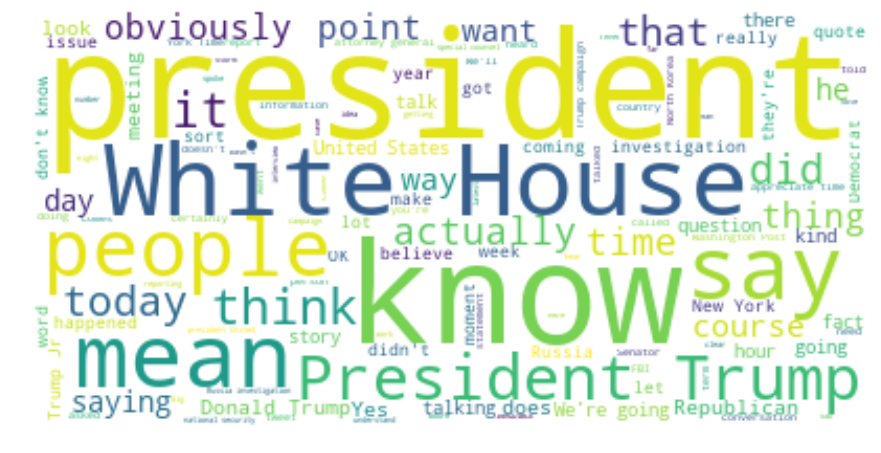

In [143]:
wc = WordCloud(background_color="white", max_words=2000,
               stopwords=stopwords)
# generate word cloud
negtext = pd.Series(df_cnn[df_cnn.Date >='2017-05-1'].Commentator_Only).str.cat(sep=' ')
wc.generate(negtext)
plt.figure(figsize = (15,15))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

plt.show()

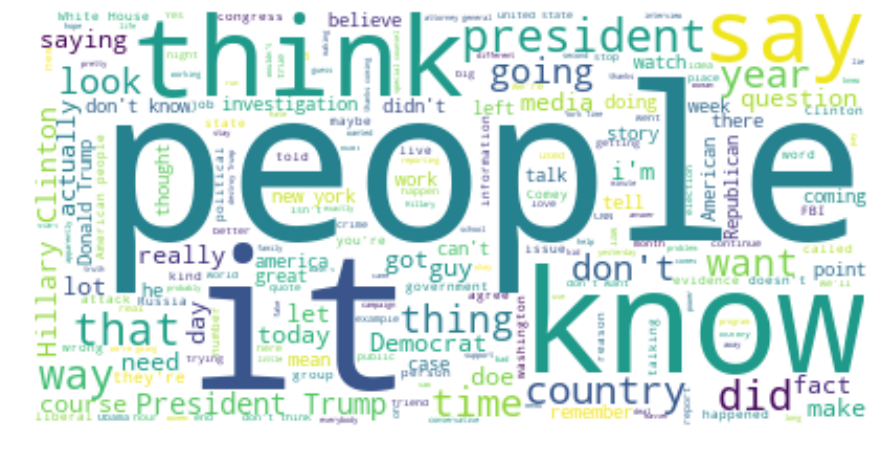

In [144]:
wc = WordCloud(background_color="white", max_words=2000,
               stopwords=stopwords)
# generate word cloud
negtext = pd.Series(df_fox_news[df_fox_news.Date >='2017-05-1'].Commentator_Only).str.cat(sep=' ')
wc.generate(negtext)
plt.figure(figsize = (15,15))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

plt.show()

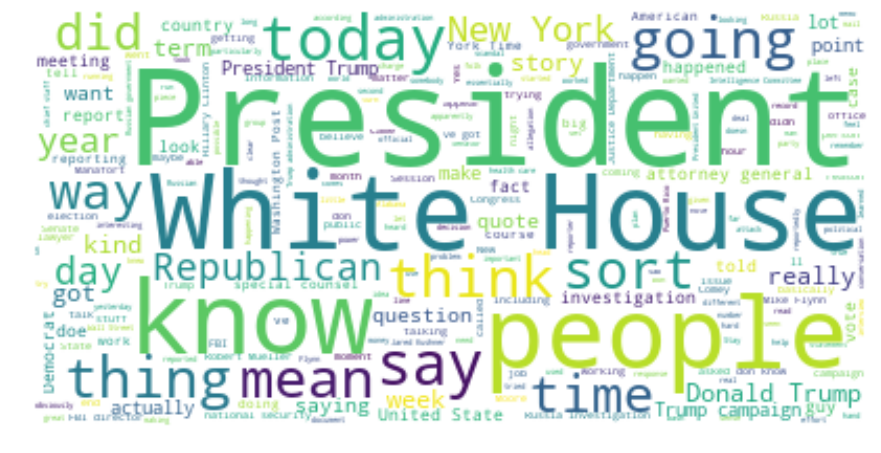

In [145]:
wc = WordCloud(background_color="white", max_words=1000,
               stopwords=stopwords)
# generate word cloud
negtext = pd.Series(df_msnbc[df_msnbc.Date >='2017-05-1'].Commentator_Only).str.cat(sep=' ')
wc.generate(negtext)
plt.figure(figsize = (15,15))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

plt.show()

In [126]:
hannity_test2 = []
for item in hannity_test:
    hannity_test2.append(re.sub('(\?|\.|\,|\:|\'s|\")','',item))
maddow_test2 = []
for item in maddow_test:
    maddow_test2.append(re.sub('(\?|\.|\,|\:|\'s|\")','',item))
cooper_test2 = []
for item in cooper_test:
    cooper_test2.append(re.sub('(\?|\.|\,|\:|\'s|\")','',item))

In [127]:
# The type of input that Word2Vec is looking for.. 

texts = [[word for word in document.lower().split() if word not in stopwords]
         for document in hannity_test2]
# The type of input that Word2Vec is looking for.. 

texts2 = [[word for word in document.lower().split() if word not in stopwords]
         for document in maddow_test2]

texts3 = [[word for word in document.lower().split() if word not in stopwords]
         for document in cooper_test2]

In [128]:
import gensim  # using skip-gram
model_wv_h = gensim.models.Word2Vec(texts, size=100, window=5, min_count=200, workers=2,sg=1)
model_wv_ac = gensim.models.Word2Vec(texts3, size=100, window=5, min_count=200, workers=2,sg=1)
model_wv_rm = gensim.models.Word2Vec(texts2, size=100, window=5, min_count=200, workers=2,sg=1)

In [123]:
model_wv_h.most_similar('trump' ,topn=20)

/Users/williamstokvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('donald', 0.8211039304733276),
 ('jr', 0.6855623126029968),
 ('course', 0.6752352714538574),
 ('called', 0.6734570264816284),
 ('media', 0.6621403098106384),
 ('actually', 0.6618673205375671),
 ('president', 0.6391141414642334),
 ('look', 0.6281424164772034),
 ('example', 0.6098059415817261),
 ('destroy', 0.6053774356842041),
 ('interview', 0.5969053506851196),
 ('democrats', 0.591585636138916),
 ('russian', 0.5898208618164062),
 ('quote', 0.5813934803009033),
 ('fake', 0.5789385437965393),
 ('today', 0.5712351202964783),
 ('liberal', 0.562563955783844),
 ('government', 0.5578934550285339),
 ('point', 0.5520807504653931),
 ('remember', 0.551776111125946)]

In [136]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

/Users/williamstokvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


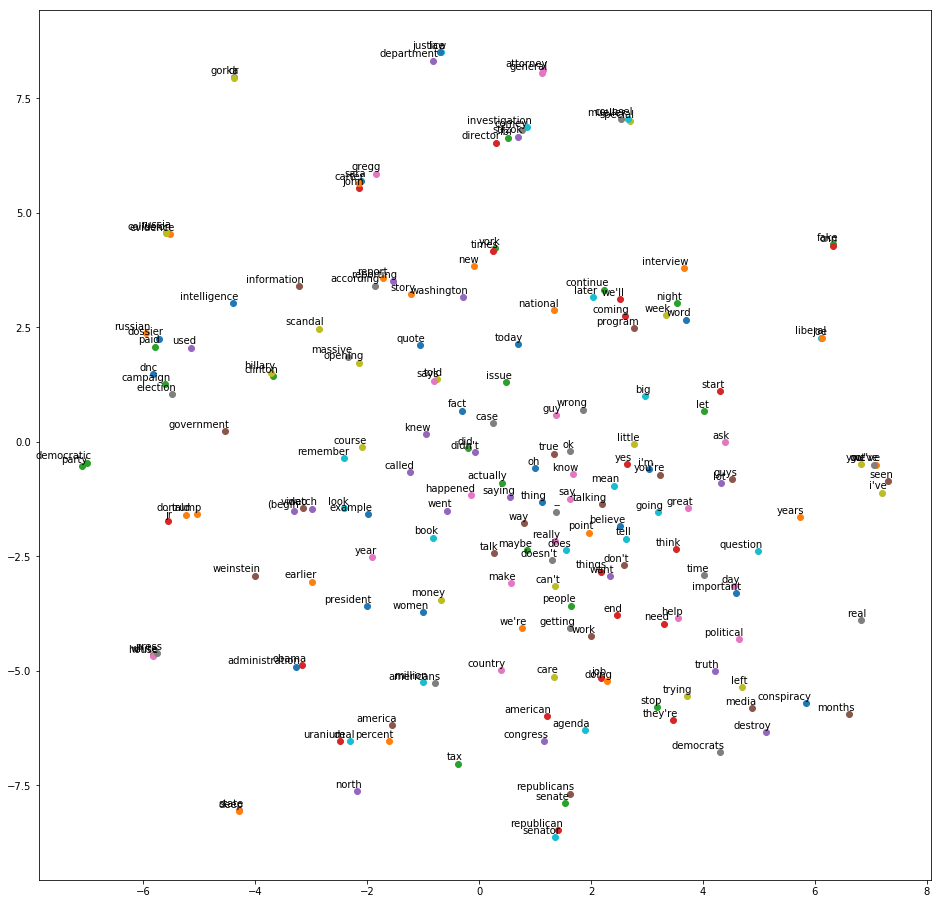

In [137]:
tsne_plot(model_wv_h)
plt.savefig('Images/Hannity_tsne.jpg')

/Users/williamstokvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


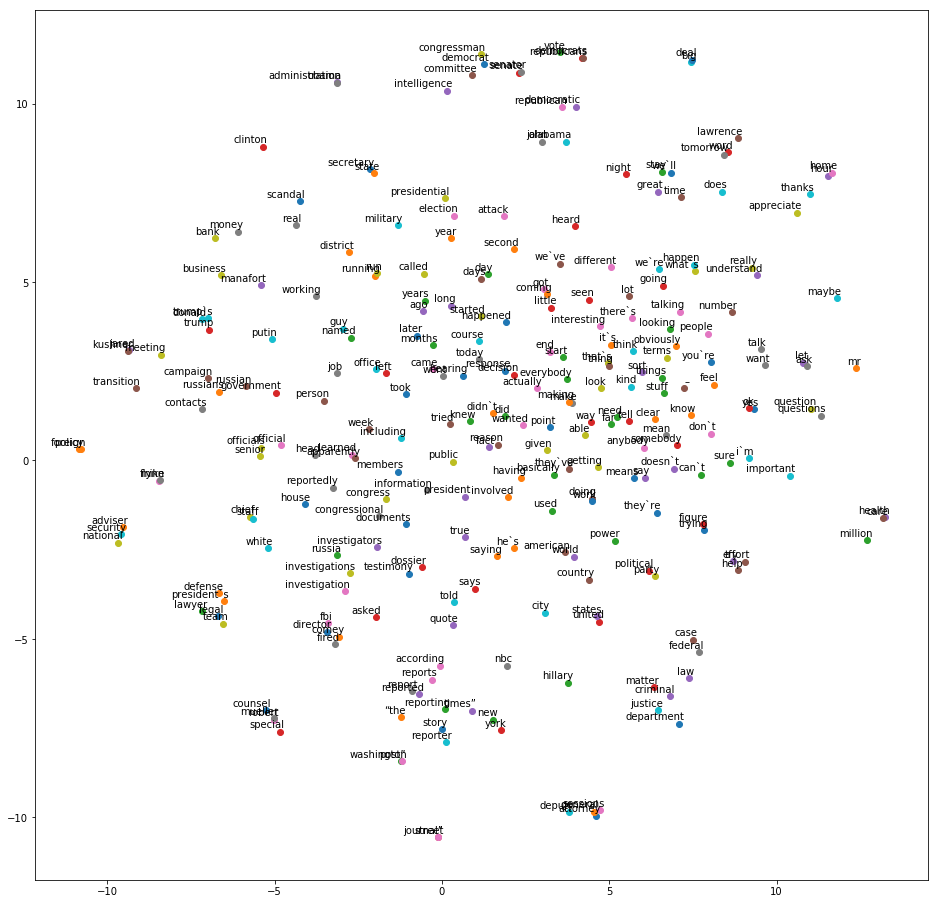

In [134]:
tsne_plot(model_wv_rm,'Images/Maddow_tsne.jpg')

/Users/williamstokvis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


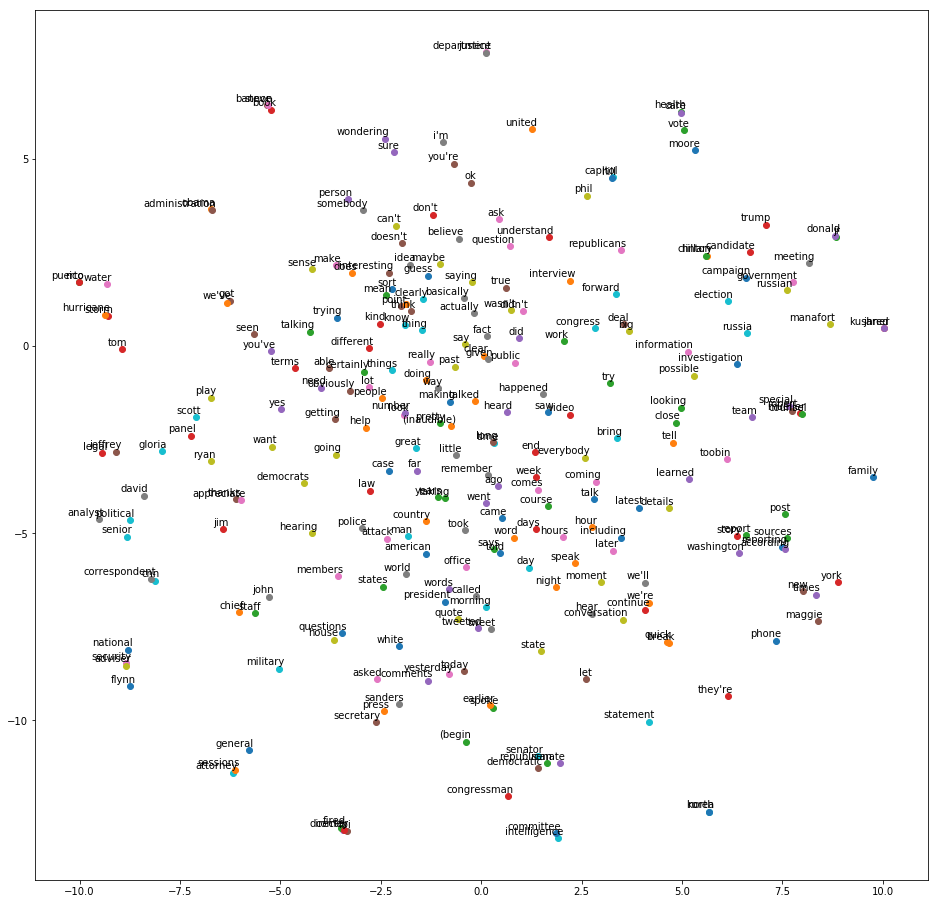

In [135]:
tsne_plot(model_wv_ac,'Images/Cooper_tsne.jpg')

## Experiment Zone

In [172]:
hannity_test[0]

'SEAN HANNITY, HOST: And welcome to "Hannity." Breaking right now, President Trump has read the classified memo showing stunning FISA abuses against his campaign. It will likely be released as early as tomorrow. Also tonight, "The Hill\'s" John Solomon reporting that Republicans are now looking to make the case that the so-called Russia investigation was based on, quote politically tainted evidence tied to Clinton loyalist. We\'ll explain. And meanwhile tonight, an all-out war on what is the truth and transparency is being waged right here in the United States of America. Fierce, unfair, opposition mounting, what? To conceal and cover up one of the biggest scandals in the history of this country. Now, Democrats led by future MSNBC contributor, Congressman Adam Schiff, they are desperately trying to block the memo from going public by lying and playing cheap partisan politics and we have the evidence. And tonight, Sara Carter is reporting that the FBI director, Christopher Wray, and the

In [406]:
commentator_test = hannity_test

In [111]:

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
docs_preprocessor(commentator_test)

In [ ]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(commentator_test, min_count=10)
trigram = Phrases(bigram[commentator_test])

for idx in range(len(commentator_test)):
    for token in bigram[commentator_test[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            commentator_test[idx].append(token)
    for token in trigram[commentator_test[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            commentator_test[idx].append(token)

In [ ]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(commentator_test)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in commentator_test]

In [1153]:
# Set training parameters.
num_topics = 7
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time plot_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

INFO:gensim.models.ldamodel:using autotuned alpha, starting with [0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715]
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 7 topics, 20 passes over the supplied corpus of 161 documents, updating model once every 161 documents, evaluating perplexity every 161 documents, iterating 400x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-8.615 per-word bound, 392.2 perplexity estimate based on a held-out corpus of 161 documents with 768985 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #161/161
INFO:gensim.models.ldamodel:optimized alpha [0.094174109, 0.12236057, 0.10866673, 0.12764247, 0.091919005, 0.10437636, 0.097591653]
INFO:gensim.models.ldamodel:topic #4 (0.092): 0.010*"fix_was" + 0.007*"law_enforcement" + 0.006*"peter_strzok" + 0.006*"justice_department" + 0.005*"responsible_for" + 0.004

INFO:gensim.models.ldamodel:topic #4 (0.047): 0.012*"fix_was" + 0.012*"peter_strzok" + 0.008*"fisa_warrant" + 0.007*"law_enforcement" + 0.007*"text_messages" + 0.007*"special_counsel_robert_mueller" + 0.007*"trump_hating" + 0.006*"dan_bongino" + 0.006*"clinton_email" + 0.006*"hannity_hotline"
INFO:gensim.models.ldamodel:topic #1 (0.050): 0.008*"next_week" + 0.007*"nancy_pelosi" + 0.006*"general_flynn" + 0.006*"ed_henry" + 0.005*"chuck_schumer" + 0.005*"exactly_what" + 0.005*"fix_was" + 0.005*"washington_d" + 0.005*"republican_party" + 0.005*"looking_at"
INFO:gensim.models.ldamodel:topic #5 (0.051): 0.025*"harvey_weinstein" + 0.014*"roy_moore" + 0.013*"fbi_informant" + 0.010*"sexual_misconduct" + 0.010*"in_2009" + 0.009*"eric_holder" + 0.008*"nbc_news" + 0.007*"justice_department" + 0.006*"democratic_party" + 0.006*"even_though"
INFO:gensim.models.ldamodel:topic #3 (0.053): 0.009*"justice_department" + 0.009*"u_n" + 0.009*"debbie_wasserman" + 0.007*"republican_lawmakers" + 0.006*"his_ag

INFO:gensim.models.ldamodel:topic diff=0.070628, rho=0.316228
INFO:gensim.models.ldamodel:-6.865 per-word bound, 116.5 perplexity estimate based on a held-out corpus of 161 documents with 768985 words
INFO:gensim.models.ldamodel:PROGRESS: pass 9, at document #161/161
INFO:gensim.models.ldamodel:optimized alpha [0.040191457, 0.036651649, 0.035220888, 0.043930259, 0.038146779, 0.039068379, 0.041776538]
INFO:gensim.models.ldamodel:topic #2 (0.035): 0.012*"liberal_joe" + 0.009*"final_word" + 0.009*"republican_party" + 0.008*"double_standard" + 0.008*"paul_manafort" + 0.007*"jeff_zucker" + 0.007*"establishment_media" + 0.007*"dr_sebastian" + 0.007*"mini_monologue" + 0.006*"then_later"
INFO:gensim.models.ldamodel:topic #1 (0.037): 0.011*"next_week" + 0.009*"nancy_pelosi" + 0.007*"ed_henry" + 0.007*"chuck_schumer" + 0.006*"republican_party" + 0.006*"exactly_what" + 0.005*"general_flynn" + 0.005*"washington_d" + 0.005*"fix_was" + 0.005*"ended_up"
INFO:gensim.models.ldamodel:topic #0 (0.040): 0

INFO:gensim.models.ldamodel:topic #6 (0.039): 0.008*"energy_independence" + 0.008*"national_anthem" + 0.006*"propaganda_media" + 0.006*"press_conference" + 0.006*"mark_levin" + 0.006*"late_night" + 0.005*"rush_limbaugh" + 0.005*"eight_years" + 0.005*"hurricane_harvey" + 0.005*"his_agenda"
INFO:gensim.models.ldamodel:topic #3 (0.039): 0.009*"u_n" + 0.009*"debbie_wasserman" + 0.009*"justice_department" + 0.008*"republican_lawmakers" + 0.008*"his_agenda" + 0.007*"kellyanne_conway" + 0.006*"under_investigation" + 0.006*"liberal_joe" + 0.006*"deputy_attorney" + 0.006*"washington_d"
INFO:gensim.models.ldamodel:topic diff=0.056936, rho=0.258199
INFO:gensim.models.ldamodel:-6.841 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 161 documents with 768985 words
INFO:gensim.models.ldamodel:PROGRESS: pass 14, at document #161/161
INFO:gensim.models.ldamodel:optimized alpha [0.037480921, 0.031909112, 0.030936578, 0.038612101, 0.034479901, 0.034230433, 0.038611498]
INFO:gensim

INFO:gensim.models.ldamodel:topic #1 (0.030): 0.014*"next_week" + 0.010*"nancy_pelosi" + 0.007*"republican_party" + 0.007*"ed_henry" + 0.007*"chuck_schumer" + 0.006*"job_done" + 0.006*"washington_d" + 0.006*"looking_at" + 0.006*"exactly_what" + 0.006*"ended_up"
INFO:gensim.models.ldamodel:topic #0 (0.036): 0.015*"9_11" + 0.013*"kathy_griffin" + 0.010*"free_speech" + 0.008*"national_anthem" + 0.007*"an_hour" + 0.007*"steve_bannon" + 0.007*"law_enforcement" + 0.007*"my_radio" + 0.007*"first_lady" + 0.007*"donna_brazile"
INFO:gensim.models.ldamodel:topic #3 (0.037): 0.009*"u_n" + 0.009*"republican_lawmakers" + 0.008*"debbie_wasserman" + 0.008*"justice_department" + 0.008*"his_agenda" + 0.007*"kellyanne_conway" + 0.007*"under_investigation" + 0.006*"deputy_attorney" + 0.006*"liberal_joe" + 0.006*"nbc_news"
INFO:gensim.models.ldamodel:topic #6 (0.037): 0.009*"energy_independence" + 0.008*"national_anthem" + 0.007*"propaganda_media" + 0.006*"press_conference" + 0.005*"mark_levin" + 0.005*"ru

CPU times: user 51.3 s, sys: 3.66 s, total: 55 s
Wall time: 52.1 s


In [1156]:
pyLDAvis.gensim.prepare(plot_model, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      18.101980        1       1 -0.160742  0.000735
3      16.244575        1       2  0.061582 -0.031149
4      15.815403        1       3 -0.107647 -0.101399
0      14.552621        1       4 -0.034886  0.168162
2      13.174844        1       5  0.090857 -0.053113
6      12.759540        1       6  0.079522  0.075266
1       9.351037        1       7  0.071314 -0.058502, topic_info=     Category         Freq                        Term        Total  loglift  \
term                                                                           
2601  Default  3360.000000            harvey_weinstein  3360.000000  30.0000   
224   Default  2031.000000                peter_strzok  2031.000000  29.0000   
2922  Default  1977.000000               fbi_informant  1977.000000  28.0000   
2622  Default  2222.000000           sexual_misconduct  2222.000000  27.0000   
2941  Default  2023.000000                        9_11  2023.000000  26.0000   
3099  Default  1505.000000               kathy_griffin  1505.000000  25.0000   
1827  Default  2134.000000                   roy_moore  2134.000000  24.0000   
2344  Default  1664.000000                 eric_holder  1664.000000  23.0000   
903   Default  2932.000000                     fix_was  2932.000000  22.0000   
1002  Default  1269.000000               text_messages  1269.000000  21.0000   
1661  Default  2612.000000                 liberal_joe  2612.000000  20.0000   
207   Default  1807.000000                   next_week  1807.000000  19.0000   
479   Default  1987.000000             national_anthem  1987.000000  18.0000   
3052  Default  1129.000000                 free_speech  1129.000000  17.0000   
409   Default  1485.000000                  final_word  1485.000000  16.0000   
1901  Default  1131.000000                 jeff_zucker  1131.000000  15.0000   
111   Default  1366.000000                fisa_warrant  1366.000000  14.0000   
2222  Default  1740.000000                     in_2009  1740.000000  13.0000   
89    Default  1479.000000                    ed_henry  1479.000000  12.0000   
2011  Default  1144.000000            money_laundering  1144.000000  11.0000   
3217  Default  1108.000000         establishment_media  1108.000000  10.0000   
1264  Default  1546.000000               paul_manafort  1546.000000   9.0000   
1533  Default  1893.000000             law_enforcement  1893.000000   8.0000   
1454  Default  1521.000000                steve_bannon  1521.000000   7.0000   
387   Default  1091.000000                 dan_bongino  1091.000000   6.0000   
2075  Default  1375.000000        republican_lawmakers  1375.000000   5.0000   
1580  Default  1672.000000                         u_n  1672.000000   4.0000   
202   Default  1758.000000                nancy_pelosi  1758.000000   3.0000   
1334  Default  1256.000000                trump_hating  1256.000000   2.0000   
1932  Default  2314.000000            republican_party  2314.000000   1.0000   
2601   Topic1  3346.166431            harvey_weinstein  3360.452733   1.7049   
2922   Topic1  1969.056861               fbi_informant  1977.576022   1.7048   
2637   Topic1   212.337482                   weinstein   213.502343   1.7037   
2939   Topic1   466.795816              uranium_market   478.269943   1.6849   
2986   Topic1   418.252784                    sold_out   432.563090   1.6755   
1410   Topic1    87.708527                   informant    91.917454   1.6623   
2565   Topic1    36.299733                    accusers    38.124069   1.6601   
3123   Topic1   159.666972          executive_producer   168.213947   1.6570   
3046   Topic1   414.581920   vladimir_putin_20_percent   440.238306   1.6491   
2362   Topic1    63.490824                      holder    68.850802   1.6281   
2459   Topic1   429.194754                 our_uranium   466.830804   1.6251   
2344   Topic1  1522.971179     